# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as colors

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf


from alens_analysis.colormaps import register_cmaps

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'

### Style settings

In [2]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

register_cmaps()
#plt.rcParams['image.cmap'] = 'emct8'
#plt.rcParams['image.cmap'] = 'warm'
plt.rcParams['image.cmap'] = 'YlOrRd'
#plt.rcParams['image.cmap'] = 'twilight'
#plt.rcParams['image.cmap'] = 'coolwarm'
#plt.rcParams['image.cmap'] = 'RdYlBu_r'
        

# Functions

In [56]:
def sd_num(h5_data):
    ydict = yaml.safe_load(h5_data.attrs['RunConfig'])
    return ydict['rngSeed']

def contiguous_regions(condition):
    """By Joe Kington, Finds contiguous True regions of the boolean array
    "condition". Returns a 2D array where the first column is the start
    index of the region and the second column is the end index.
    http://stackoverflow.com/questions/4494404/find-large-number-of-consecutive-values-fulfilling-condition-in-a-numpy-array"""

    # Find the indices of changes in "condition"
    diff = np.diff(condition.astype(int))
    idx, = diff.nonzero()

    # We need to start things after the change in "condition". Therefore,
    # we'll  shift the index by 1 to the right.
    idx += 1

    if condition[0]:
        # if the end of the start of condition is True prepend a 0
        idx = np.r_[0, idx]

    if condition[-1]:
        # if the end of condtion is True, append the length of the array
        idx = np.r_[idx, condition.size]

    idx.shape = (-1, 2)
    return idx

def collect_contiguous_intervals(arr, delta):
    """ Collect and return different contiguous regions of an array. """
    arr_deriv = np.gradient(arr, delta)

    # Get a matrix of indices. First column is starting point of positive
    # interval, second column is ending point of positive interval
    contig_idx_arr = contiguous_regions(arr_deriv > 0)
    start_pos = contig_idx_arr[:, 0]
    end_pos = contig_idx_arr[:, 1]
    pos_lengths = (end_pos - start_pos) * 1.
    neg_lengths = (start_pos[1:] - end_pos[:-1]) * 1.

    return arr_deriv, contig_idx_arr, pos_lengths, neg_lengths

def identify_spatial_clusters(com_arr, eps=0.05, min_samples=15, thresh=20):
    clust = OPTICS(min_samples=15, eps=0.05, min_cluster_size=100, cluster_method='dbscan')
    clust.fit(com_arr)
    labels = clust.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("number of estimated clusters : %d" % n_clusters_)

    # Collect a list of cluster centers and the list of their labels
    cluster_centers = []
    cluster_label_inds = []
    for k in range(n_clusters_):
        cli = np.where(labels == k)[0]
        if cli.size < thresh:
            continue
        cluster_label_inds += [ cli ]
        cluster_centers += [com_arr[cli,:].mean(axis=0)]
    
    return clust, cluster_centers, cluster_label_inds

def graph_clust_snapshot(com_arr, clust, cluster_centers, cluster_member_inds):
    n_clusters = len(cluster_centers)

    labels = clust.labels_

    _ = axarr[0].scatter(com_arr[:, 0], com_arr[:, 1])
    _ = axarr[1].scatter(com_arr[:, 0], com_arr[:, 2])
    _ = axarr[0].set_ylabel('Y ($\mu$m)')
    _ = axarr[1].set_ylabel('Z ($\mu$m)')
    _ = axarr[3].set_xlabel('X ($\mu$m)')


    for k, my_members, col in zip(range(n_clusters), cluster_member_inds, colors):
        cluster_center = cluster_centers[k]
        _ = axarr[2].scatter(com_arr[my_members, 0], com_arr[my_members, 1], color=col)
        _ = axarr[3].scatter(com_arr[my_members, 0], com_arr[my_members, 2], color=col)
        _ = axarr[2].plot(
                cluster_center[0],
                cluster_center[1],
                "o",
                markerfacecolor=col,
                markeredgecolor="k",
                markersize=14,
            )
        _ = axarr[3].plot(
            cluster_center[0],
            cluster_center[2],
            "o",
            markerfacecolor=col,
            markeredgecolor="k",
            markersize=14,
        )

    _ = axarr[2].set_ylabel('Y ($\mu$m)')
    _ = axarr[3].set_ylabel('Z ($\mu$m)')
    for ax in axarr:
        _ = ax.set_aspect(1)

    return fig, axarr
    

    
    


# Results/Graphs

## Single snapshot clusters

number of estimated clusters : 4
number of thresholded clusters : 3


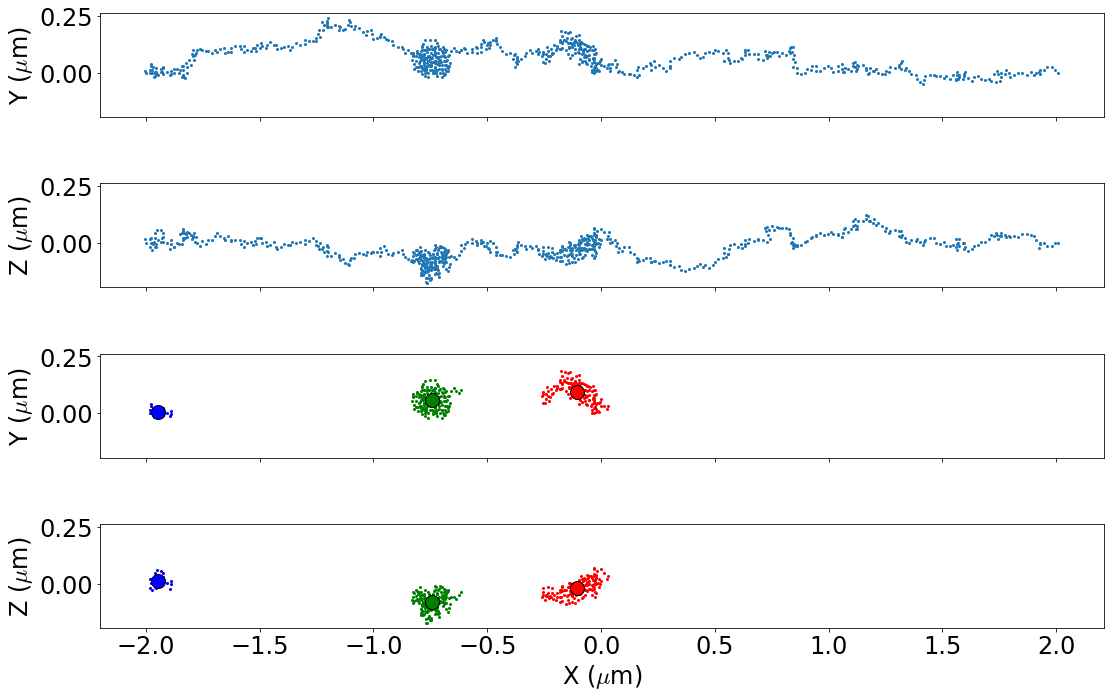

In [6]:
data_path = (ceph_path /"21_aLchr1_700_runs/21-11-30_aLchr1_scan.12_line700_2xsticky_conf/simulations/s10")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
        com_arr[:, :, -1])
    
    
    cgf.graph_clust_snapshot(axarr, com_arr[:,:,-1], clust, cluster_centers, cluster_label_inds)
   
  

number of estimated clusters : 6


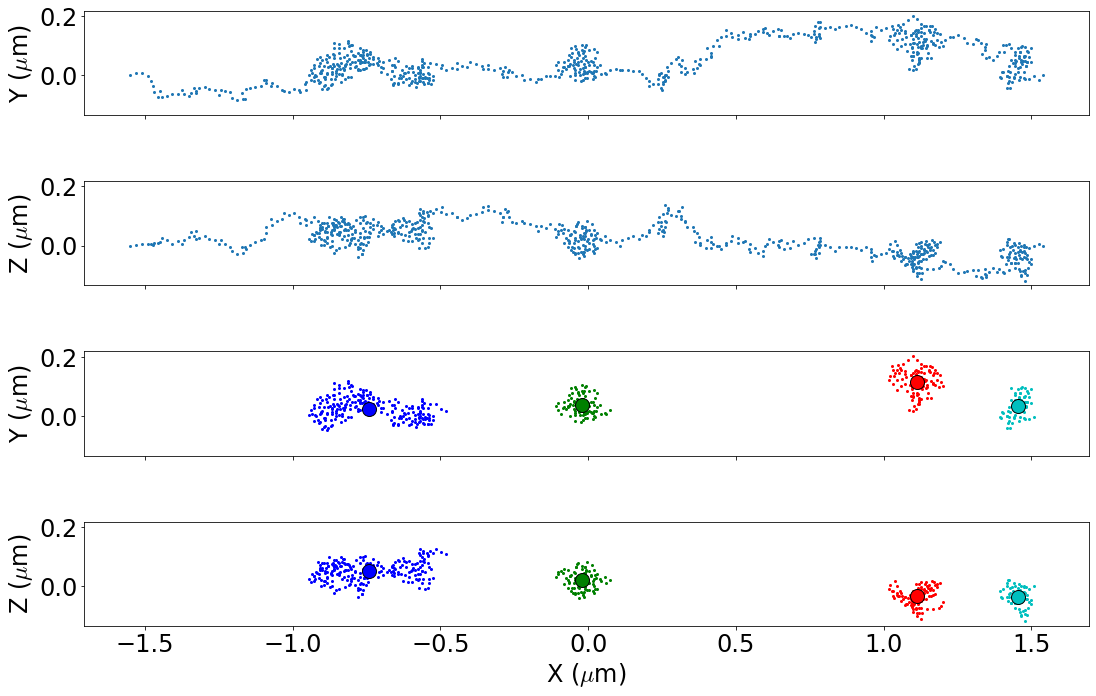

In [ ]:
data_path = (ceph_path /"21-12-05_aLchr1_scan.12_line700_2xsticky_3umconf/simulations/s10")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

   
fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    # clust, cluster_centers, cluster_label_inds = aac.chromatin_condensate_analysis.identify_spatial_clusters(
    #     com_arr[:, :, -1])
    clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
        com_arr[:, :, 500])
    
    cgf.graph_clust_snapshot(axarr, com_arr[:,:,500], clust, cluster_centers, cluster_label_inds)
    
    #bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

number of estimated clusters : 5


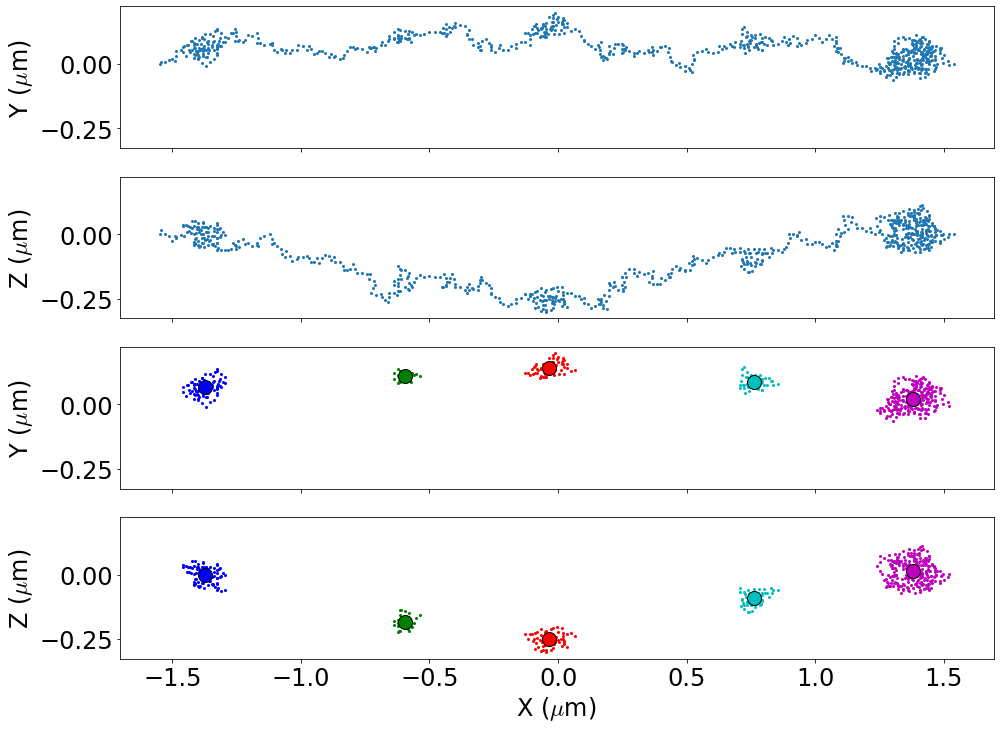

In [ ]:
data_path = (ceph_path /"21-12-05_aLchr1_scan.12_line700_2xsticky_3umconf/simulations/s10")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    # clust, cluster_centers, cluster_label_inds = aac.chromatin_condensate_analysis.identify_spatial_clusters(
    #     com_arr[:, :, -1])
    clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
        com_arr[:, :, -1])
    
    cgf.graph_clust_snapshot(axarr, com_arr[:,:,-1], clust, cluster_centers, cluster_label_inds)



findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


number of estimated clusters : 2
number of thresholded clusters : 2


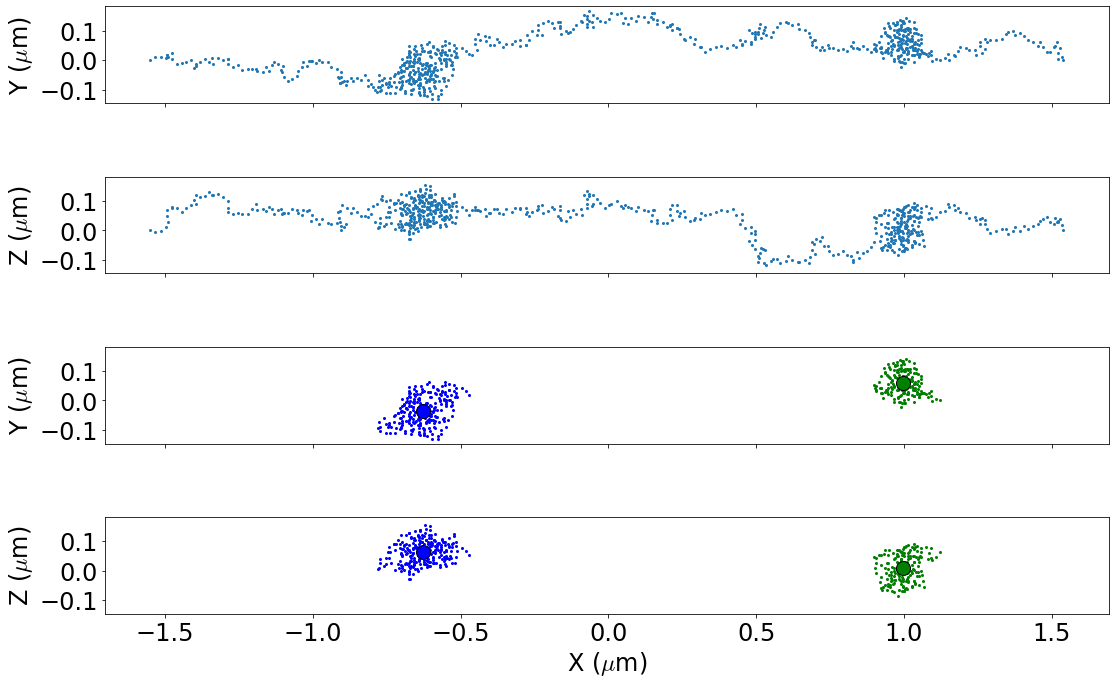

In [3]:
data_path = (
    ceph_path / "22_aLchr700_sticky_runs/22-01-02_aLchr1_scan.12_line700_2xsticky_3umconf_eq/simulations/s6")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
        com_arr[:, :, -1])
    
    
    cgf.graph_clust_snapshot(axarr, com_arr[:,:,-1], clust, cluster_centers, cluster_label_inds)



In [5]:
def dist_vs_idx_dist(com_arr):
    sep_mat = np.linalg.norm(com_arr[:, np.newaxis, :] - com_arr[np.newaxis, :, :], axis=2)
    avg_dist_arr = np.zeros((sep_mat.shape[0]))
    avg_dist_sem_arr = np.zeros((sep_mat.shape[0]))
    for i in range(1,sep_mat.shape[0]):
        diag = np.diagonal(sep_mat, i)
        avg_dist_arr[i] = diag.mean()
        avg_dist_sem_arr[i] = stats.sem(diag)
    return avg_dist_arr, avg_dist_sem_arr
    

number of estimated clusters : 2
number of thresholded clusters : 2
Volume of condensate: 3671780.374228862 nm$^3$
Volume per bead: 15048.280222249436 nm$^3$
Volume of condensate: 2584544.201717821 nm$^3$
Volume per bead: 14853.702308723108 nm$^3$


/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


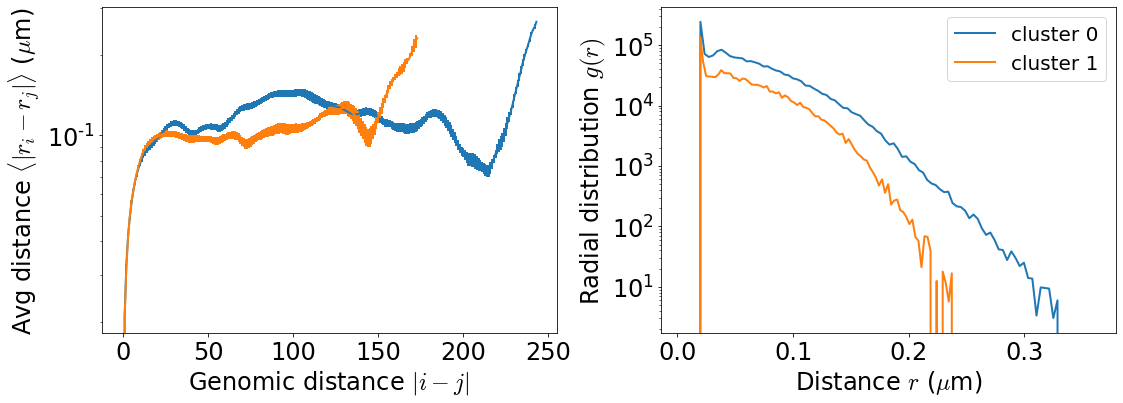

In [118]:
data_path = (
    ceph_path / "22_aLchr700_sticky_runs/22-01-02_aLchr1_scan.12_line700_2xsticky_3umconf_eq/simulations/s6")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
t = -1 # Snapshot time to use

fig, axarr = plt.subplots(1,2, figsize=(16, 6))

with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, t] + sy_dat[:, 5:8, t])

    clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
        com_arr)

    for i, cli in enumerate(cluster_label_inds):
        clust_ind_com = com_arr[cli]
        hull = ConvexHull(clust_ind_com)
        print(f"Volume of condensate: {1e9*hull.volume} nm$^3$")
        print(f"Volume per bead: {1e9*hull.volume/float(clust_ind_com.shape[0])} nm$^3$")

        avg_dist_arr, avg_dist_sem_arr = dist_vs_idx_dist(clust_ind_com) 
        dist_mat = np.linalg.norm((clust_ind_com[:, np.newaxis, :] -
                               clust_ind_com[np.newaxis, :, :]),
                              axis=2)
        rad_distr_func, rad_bin_edges = ca.rad_distr_func_at_t(dist_mat, hist_max=1.1*np.max(dist_mat))
    
        _ = axarr[0].errorbar(np.arange(len(avg_dist_arr)), avg_dist_arr, yerr=avg_dist_sem_arr, label=f'cluster {i}')
        _ = axarr[1].plot(rad_bin_edges[1:], rad_distr_func[1:]*hull.volume, label=f'cluster {i}')


_ = axarr[0].set_yscale("log")
_ = axarr[1].set_yscale("log")

_ = axarr[0].set_xlabel(r"Genomic distance $|i - j|$ ")
_ = axarr[0].set_ylabel(r"Avg distance $\langle |r_i - r_j|\rangle$ ($\mu$m)")
_ = axarr[1].set_xlabel(r"Distance $r$ ($\mu$m)")
_ = axarr[1].set_ylabel(r"Radial distribution $g(r)$")

# _ = axarr[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
_ = axarr[1].legend()
fig.tight_layout()
# cgf.graph_clust_snapshot(axarr, com_arr[:,:,-1], clust, cluster_centers, cluster_label_inds)



number of estimated clusters : 4
number of thresholded clusters : 2
Volume of condensate: 3319154.349682354 nm$^3$
Volume per bead: 15225.478668267679 nm$^3$
Volume of condensate: 2224914.4070520857 nm$^3$
Volume per bead: 12935.5488782098 nm$^3$


/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


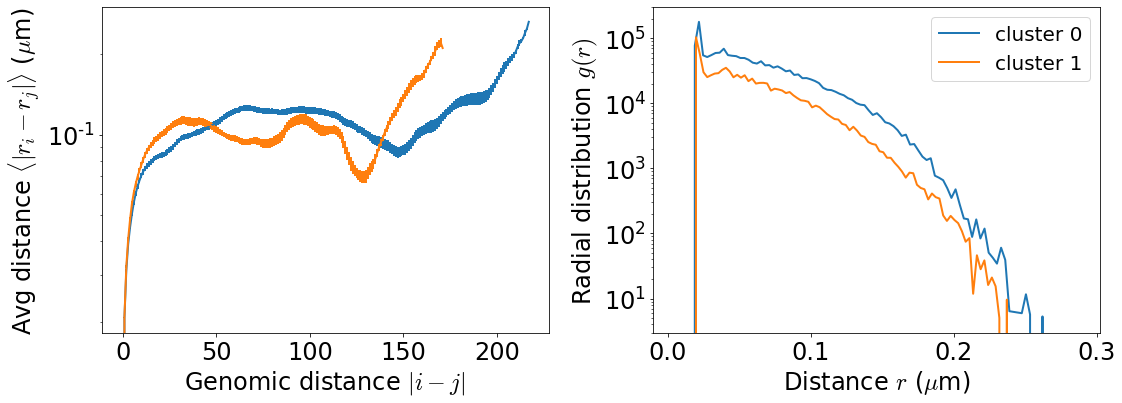

In [120]:
data_path = (
    ceph_path / "22_aLchr700_sticky_runs/22-01-02_aLchr1_scan.12_line700_2xsticky_3umconf_eq/simulations/s6")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
t = -1000 # Snapshot time to use

fig, axarr = plt.subplots(1,2, figsize=(16, 6))

with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, t] + sy_dat[:, 5:8, t])

    clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
        com_arr)

    for i, cli in enumerate(cluster_label_inds):
        clust_ind_com = com_arr[cli]
        hull = ConvexHull(clust_ind_com)
        print(f"Volume of condensate: {1e9*hull.volume} nm$^3$")
        print(f"Volume per bead: {1e9*hull.volume/float(clust_ind_com.shape[0])} nm$^3$")

        avg_dist_arr, avg_dist_sem_arr = dist_vs_idx_dist(clust_ind_com) 
        dist_mat = np.linalg.norm((clust_ind_com[:, np.newaxis, :] -
                               clust_ind_com[np.newaxis, :, :]),
                              axis=2)
        rad_distr_func, rad_bin_edges = ca.rad_distr_func_at_t(dist_mat, hist_max=1.1*np.max(dist_mat))
    
        _ = axarr[0].errorbar(np.arange(len(avg_dist_arr)), avg_dist_arr, yerr=avg_dist_sem_arr, label=f'cluster {i}')
        _ = axarr[1].plot(rad_bin_edges[1:], rad_distr_func[1:]*hull.volume, label=f'cluster {i}')


_ = axarr[0].set_yscale("log")
_ = axarr[1].set_yscale("log")

_ = axarr[0].set_xlabel(r"Genomic distance $|i - j|$ ")
_ = axarr[0].set_ylabel(r"Avg distance $\langle |r_i - r_j|\rangle$ ($\mu$m)")
_ = axarr[1].set_xlabel(r"Distance $r$ ($\mu$m)")
_ = axarr[1].set_ylabel(r"Radial distribution $g(r)$")

# _ = axarr[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
_ = axarr[1].legend()
fig.tight_layout()



    
    
    
    
    # cgf.graph_clust_snapshot(axarr, com_arr[:,:,-1], clust, cluster_centers, cluster_label_inds)



## Single cluster characterization

/tmp/ipykernel_2784479/1479522363.py:36: RuntimeWarning: invalid value encountered in true_divide
  _ = axarr[1].plot(cond_data[:,0], volume_arr/bead_arr, label = f'Condensate {ci}')


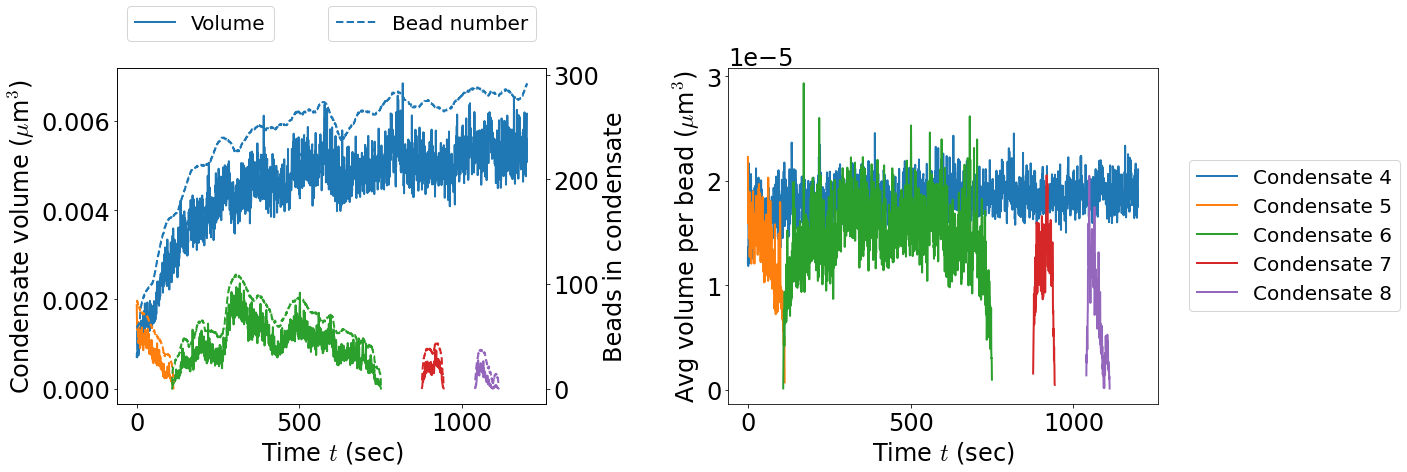

In [53]:
data_path = (
    ceph_path / "22_aLc800_sticky_runs/22-04-15_aLc1_scan.32_line800_sticky_5umconf_2cond100sep200/simulations/s5")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(1,2, figsize=(20, 7))
axarr0 = axarr[0].twinx()

with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    for ci, cond_str in enumerate(h5_data['analysis/condensates']):
        cond_data = h5_data[f'analysis/condensates/{cond_str}']
        if cond_data.shape[0] < 100:
            continue
        # print(cond_data)
        volume_arr = np.zeros(cond_data.shape[0])
        bead_arr = np.zeros(cond_data.shape[0])
        for i, cdat in enumerate(cond_data):
            t = np.where(time_arr == cdat[0])[0][0]
            parts = com_arr[int(cdat[1]):int(cdat[2]+1), :, t] 
            if parts.shape[0] < 3:
                continue
            hull = ConvexHull(parts)
            volume_arr[i] = hull.volume
            bead_arr[i] = parts.shape[0]
        
        _ = axarr[0].plot(cond_data[:,0], volume_arr)
        _ = axarr0.plot(cond_data[:,0], bead_arr,  linestyle='--')
        _ = axarr[1].plot(cond_data[:,0], volume_arr/bead_arr, label = f'Condensate {ci}')

_ = axarr[0].legend(['Volume'], loc='lower left', bbox_to_anchor=(0., 1.05))
_ = axarr0.legend(['Bead number'], loc='lower right', bbox_to_anchor=(1., 1.05))
_ = axarr[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
for ax in axarr:
    _ = ax.set_xlabel('Time $t$ (sec)')
_ = axarr[0].set_ylabel('Condensate volume ($\mu$m$^3$)')
_ = axarr0.set_ylabel('Beads in condensate')
_ = axarr[1].set_ylabel('Avg volume per bead ($\mu$m$^3$)')

fig.tight_layout() 
    
        

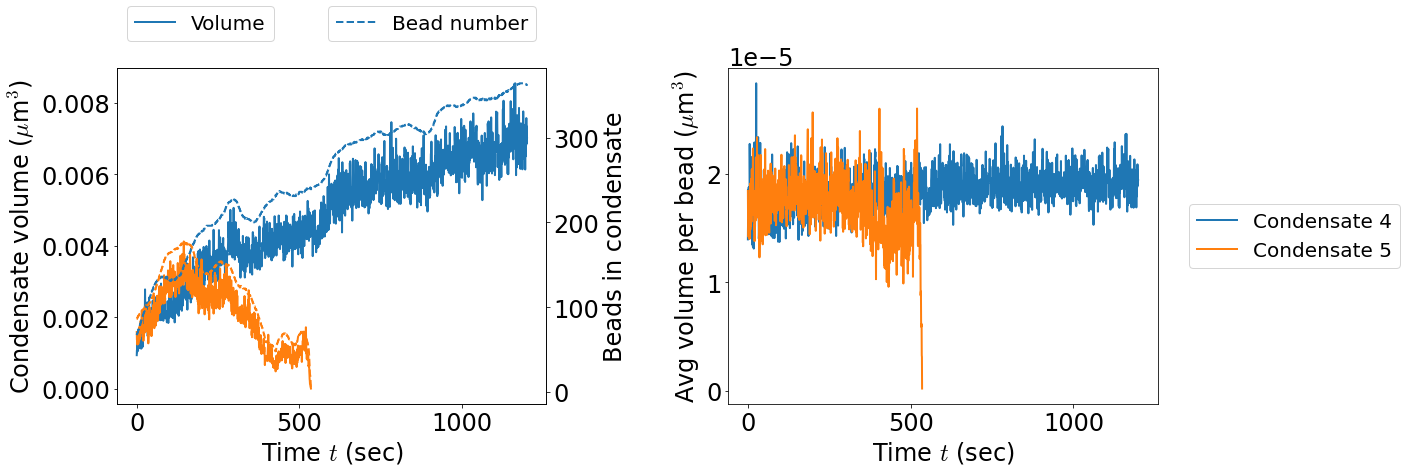

In [54]:
data_path = (
    ceph_path / "22_aLc800_sticky_runs/22-04-15_aLc1_scan.32_line800_sticky_5umconf_2cond100sep200/simulations/s6")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(1,2, figsize=(20, 7))
axarr0 = axarr[0].twinx()

with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    for ci, cond_str in enumerate(h5_data['analysis/condensates']):
        cond_data = h5_data[f'analysis/condensates/{cond_str}']
        if cond_data.shape[0] < 100:
            continue
        # print(cond_data)
        volume_arr = np.zeros(cond_data.shape[0])
        bead_arr = np.zeros(cond_data.shape[0])
        for i, cdat in enumerate(cond_data):
            t = np.where(time_arr == cdat[0])[0][0]
            parts = com_arr[int(cdat[1]):int(cdat[2]+1), :, t] 
            if parts.shape[0] < 3:
                continue
            hull = ConvexHull(parts)
            volume_arr[i] = hull.volume
            bead_arr[i] = parts.shape[0]
        
        _ = axarr[0].plot(cond_data[:,0], volume_arr)
        _ = axarr0.plot(cond_data[:,0], bead_arr,  linestyle='--')
        _ = axarr[1].plot(cond_data[:,0], volume_arr/bead_arr, label = f'Condensate {ci}')

_ = axarr[0].legend(['Volume'], loc='lower left', bbox_to_anchor=(0., 1.05))
_ = axarr0.legend(['Bead number'], loc='lower right', bbox_to_anchor=(1., 1.05))
_ = axarr[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
for ax in axarr:
    _ = ax.set_xlabel('Time $t$ (sec)')
_ = axarr[0].set_ylabel('Condensate volume ($\mu$m$^3$)')
_ = axarr0.set_ylabel('Beads in condensate')
_ = axarr[1].set_ylabel('Avg volume per bead ($\mu$m$^3$)')

fig.tight_layout() 
    
        

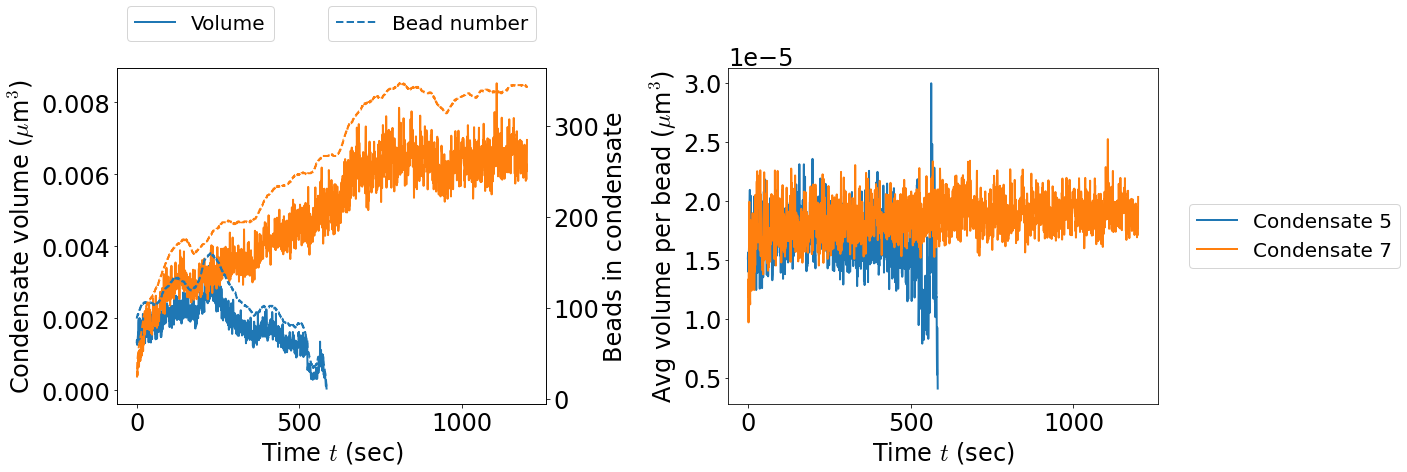

In [55]:
data_path = (
    ceph_path / "22_aLc800_sticky_runs/22-04-15_aLc1_scan.32_line800_sticky_5umconf_2cond100sep200/simulations/s20")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(1,2, figsize=(20, 7))
axarr0 = axarr[0].twinx()

with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    for ci, cond_str in enumerate(h5_data['analysis/condensates']):
        cond_data = h5_data[f'analysis/condensates/{cond_str}']
        if cond_data.shape[0] < 100:
            continue
        # print(cond_data)
        volume_arr = np.zeros(cond_data.shape[0])
        bead_arr = np.zeros(cond_data.shape[0])
        for i, cdat in enumerate(cond_data):
            t = np.where(time_arr == cdat[0])[0][0]
            parts = com_arr[int(cdat[1]):int(cdat[2]+1), :, t] 
            if parts.shape[0] < 3:
                continue
            hull = ConvexHull(parts)
            volume_arr[i] = hull.volume
            bead_arr[i] = parts.shape[0]
        
        _ = axarr[0].plot(cond_data[:,0], volume_arr)
        _ = axarr0.plot(cond_data[:,0], bead_arr,  linestyle='--')
        _ = axarr[1].plot(cond_data[:,0], volume_arr/bead_arr, label = f'Condensate {ci}')

_ = axarr[0].legend(['Volume'], loc='lower left', bbox_to_anchor=(0., 1.05))
_ = axarr0.legend(['Bead number'], loc='lower right', bbox_to_anchor=(1., 1.05))
_ = axarr[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
for ax in axarr:
    _ = ax.set_xlabel('Time $t$ (sec)')
_ = axarr[0].set_ylabel('Condensate volume ($\mu$m$^3$)')
_ = axarr0.set_ylabel('Beads in condensate')
_ = axarr[1].set_ylabel('Avg volume per bead ($\mu$m$^3$)')

fig.tight_layout() 
    
        

/tmp/ipykernel_2784479/3303371598.py:41: RuntimeWarning: invalid value encountered in true_divide
  _ = axarr[1].plot(cond_time, volume_arr/bead_arr, label = f'Seed: {sd_num(h5_data)}')
/tmp/ipykernel_2784479/3303371598.py:42: RuntimeWarning: invalid value encountered in true_divide
  _ = axarr[1].hlines((volume_arr/bead_arr).mean(), time_arr[0], time_arr[-1])
/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/tmp/ipykernel_2784479/3303371598.py:41: RuntimeWarning: invalid value encountered in true_divide
  _ = axarr[1].plot(cond_time, volume_arr/bead_arr, label = f'Seed: {sd_num(h5_data)}')
/tmp/ipykernel_2784479/3303371598.py:42: RuntimeWarning: invalid value encountered in true_divide
  _ = axarr[1].hlines((volume_arr/bead_arr).mean(), time_arr[0], time_arr[-1])
/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_a

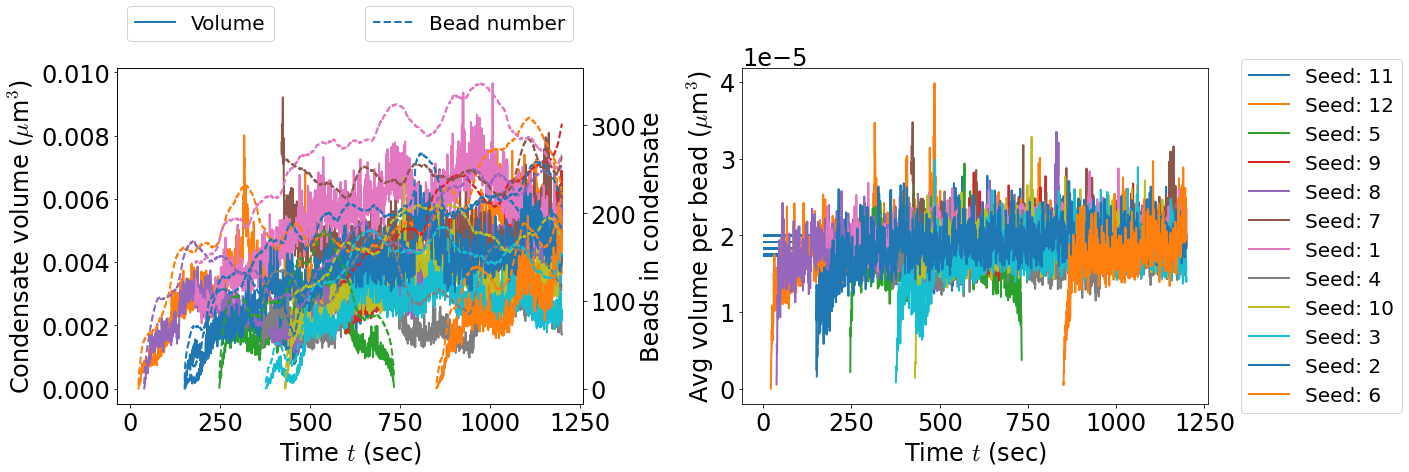

In [63]:
data_path = (
    ceph_path / "22_aLc800_sticky_runs/22-04-15_aLchr1_scan7.12_line800_stickyL.01-.07_eps1_Ke30_5umconf/simulations/Ls0.04")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(1,2, figsize=(20, 7))
axarr0 = axarr[0].twinx()

for h5_file in data_path.glob('*/analysis/*.h5'):
    with h5py.File(h5_file, 'r+') as h5_data:
        time_arr = h5_data['time'][ss_ind:end_ind]
        analysis_grp = h5_data['analysis']

        sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                            :, ss_ind:end_ind]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        largest_cond = 0
        for ci, cond_str in enumerate(h5_data['analysis/condensates']):
            cond_data = h5_data[f'analysis/condensates/{cond_str}']
            max_cond_size = np.max(cond_data[:,2] -cond_data[:, 1])
            if max_cond_size < largest_cond:
                continue
            largest_cond = max_cond_size
            cond_time = cond_data[:,0]
            # print(cond_data)
            volume_arr = np.zeros(cond_data.shape[0])
            bead_arr = np.zeros(cond_data.shape[0])
            for i, cdat in enumerate(cond_data):
                t = np.where(time_arr == cdat[0])[0][0]
                parts = com_arr[int(cdat[1]):int(cdat[2]+1), :, t] 
                if parts.shape[0] < 4:
                    continue
                hull = ConvexHull(parts)
                volume_arr[i] = hull.volume
                bead_arr[i] = parts.shape[0]
            
        _ = axarr[0].plot(cond_time, volume_arr)
        _ = axarr0.plot(cond_time, bead_arr,  linestyle='--')
        _ = axarr[1].plot(cond_time, volume_arr/bead_arr, label = f'Seed: {sd_num(h5_data)}')
        _ = axarr[1].hlines((volume_arr/bead_arr).mean(), time_arr[0], time_arr[-1])

    _ = axarr[0].legend(['Volume'], loc='lower left', bbox_to_anchor=(0., 1.05))
    _ = axarr0.legend(['Bead number'], loc='lower right', bbox_to_anchor=(1., 1.05))
    _ = axarr[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    for ax in axarr:
        _ = ax.set_xlabel('Time $t$ (sec)')
    _ = axarr[0].set_ylabel('Condensate volume ($\mu$m$^3$)')
    _ = axarr0.set_ylabel('Beads in condensate')
    _ = axarr[1].set_ylabel('Avg volume per bead ($\mu$m$^3$)')

fig.tight_layout() 
    
        

In [ ]:
data_path = (ceph_path / "22_aLc800_sticky_runs/22-04-15_aLchr1_scan7.12_line800_stickyL.01-.07_eps1_Ke30_5umconf/simulations")
param_list = [0.04, 0.05, 0.06, 0.07]
# param_list = ["0.04", "0.05", "0.06", "0.07"]
param_paths = [data_path / f"Ls{p}" for p in param_list]
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

volume_seed_avg_arr = []
num_bead_seed_avg_arr = []
bead_vol_seed_avg_arr = []
for ppaths in param_paths:
    volume_mean_arr = []
    num_bead_mean_arr = []
    bead_vol_mean_arr = []
    for h5_file in ppaths.glob('*/analysis/*.h5'):
        with h5py.File(h5_file, 'r+') as h5_data:
            time_arr = h5_data['time'][ss_ind:end_ind]
            analysis_grp = h5_data['analysis']
            
            try:
                sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                                :, ss_ind:end_ind]
            except:
                print(f"No sylinder data in {sd_num(h5_data)}.")
                continue
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            largest_cond = 0
            for ci, cond_str in enumerate(h5_data['analysis/condensates']):
                cond_data = h5_data[f'analysis/condensates/{cond_str}']
                max_cond_size = np.max(cond_data[:,2] -cond_data[:, 1])
                if max_cond_size < largest_cond:
                    continue
                largest_cond = max_cond_size
                cond_time = cond_data[:,0]
                # print(cond_data)
                volume_arr = np.zeros(cond_data.shape[0])
                bead_arr = np.zeros(cond_data.shape[0])
                for i, cdat in enumerate(cond_data):
                    t = np.where(time_arr == cdat[0])[0][0]
                    parts = com_arr[int(cdat[1]):int(cdat[2]+1), :, t] 
                    if parts.shape[0] < 4:
                        continue
                    hull = ConvexHull(parts)
                    volume_arr[i] = hull.volume
                    bead_arr[i] = parts.shape[0]
            volume_mean_arr += [volume_arr.mean()]
            num_bead_mean_arr += [bead_arr.mean()]
            bead_vol_mean_arr += [(volume_arr/bead_arr).mean()]
                
    volume_seed_avg_arr += [volume_mean_arr]
    num_bead_seed_avg_arr += [num_bead_mean_arr]
    bead_vol_seed_avg_arr += [bead_vol_mean_arr]
                
            # _ = axarr[0].plot(cond_time, volume_arr)
            # _ = axarr0.plot(cond_time, bead_arr,  linestyle='--')
            # _ = axarr[1].plot(cond_time, volume_arr/bead_arr, label = f'Seed: {sd_num(h5_data)}')
            # _ = axarr[1].hlines((volume_arr/bead_arr).mean(), time_arr[0], time_arr[-1])
fig, axarr = plt.subplots(1,3, figsize=(25, 6))
#print(volume_seed_avg_arr)
#print(np.ma.masked_invalid(np.array(bead_vol_seed_avg_arr)))
_ = axarr[0].violinplot(volume_seed_avg_arr)
_ = axarr[1].violinplot(num_bead_seed_avg_arr)
bvsaa = [ np.array(a)[~np.isnan(a)] for a in bead_vol_seed_avg_arr]

_ = axarr[2].violinplot(bvsaa)
        # _ = axarr[0].legend(['Volume'], loc='lower left', bbox_to_anchor=(0., 1.05))
        # _ = axarr0.legend(['Bead number'], loc='lower right', bbox_to_anchor=(1., 1.05))
        # _ = axarr[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
        # for ax in axarr:
        #     _ = ax.set_xlabel('Time $t$ (sec)')
        # _ = axarr[0].set_ylabel('Condensate volume ($\mu$m$^3$)')
        # _ = axarr0.set_ylabel('Beads in condensate')
        # _ = axarr[1].set_ylabel('Avg volume per bead ($\mu$m$^3$)')

fig.tight_layout() 
    
        

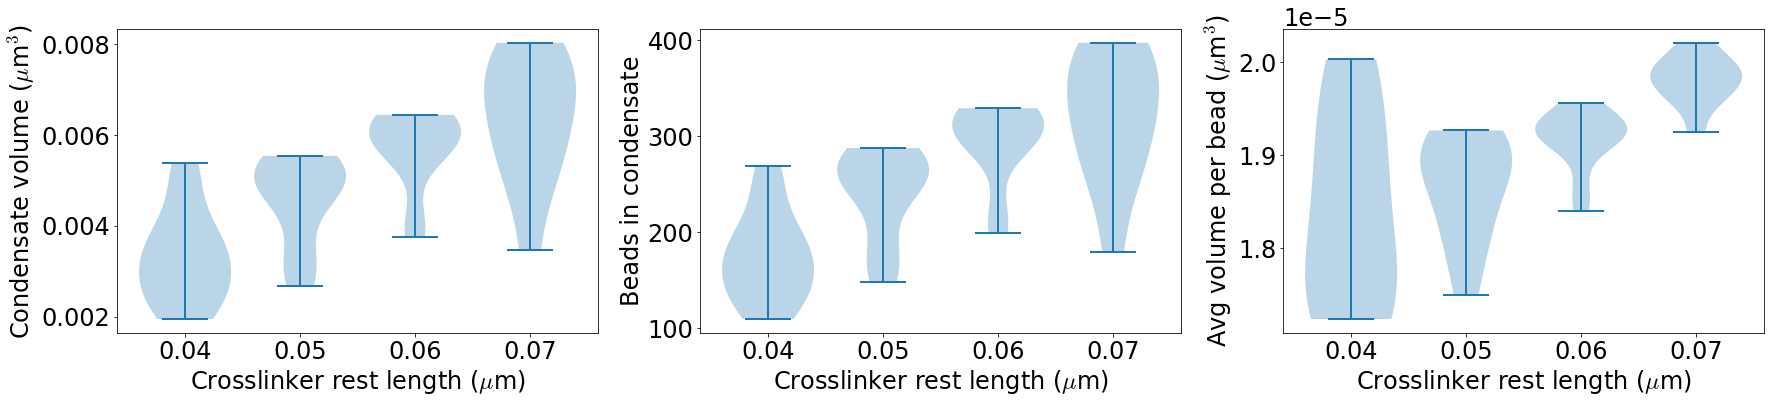

In [97]:
fig, axarr = plt.subplots(1,3, figsize=(25, 6))
#print(volume_seed_avg_arr)
#print(np.ma.masked_invalid(np.array(bead_vol_seed_avg_arr)))
_ = axarr[0].violinplot(volume_seed_avg_arr, positions=param_list, widths=.8*(param_list[1]-param_list[0]))
_ = axarr[1].violinplot(num_bead_seed_avg_arr, positions=param_list,widths=.8*(param_list[1]-param_list[0]))
bvsaa = [ np.array(a)[~np.isnan(a)] for a in bead_vol_seed_avg_arr]

_ = axarr[2].violinplot(bvsaa, positions=param_list,widths=.8*(param_list[1]-param_list[0]))
for ax in axarr:
    _ = ax.set_xlabel('Crosslinker rest length ($\mu$m)')
_ = axarr[0].set_ylabel('Condensate volume ($\mu$m$^3$)')
_ = axarr[1].set_ylabel('Beads in condensate')
_ = axarr[2].set_ylabel('Avg volume per bead ($\mu$m$^3$)')

fig.tight_layout()

## Large simulations

number of estimated clusters : 41
number of thresholded clusters : 37


(-10.0, 10.0)

(-10.0, 10.0)

(-10.0, 10.0)

(-10.0, 10.0)

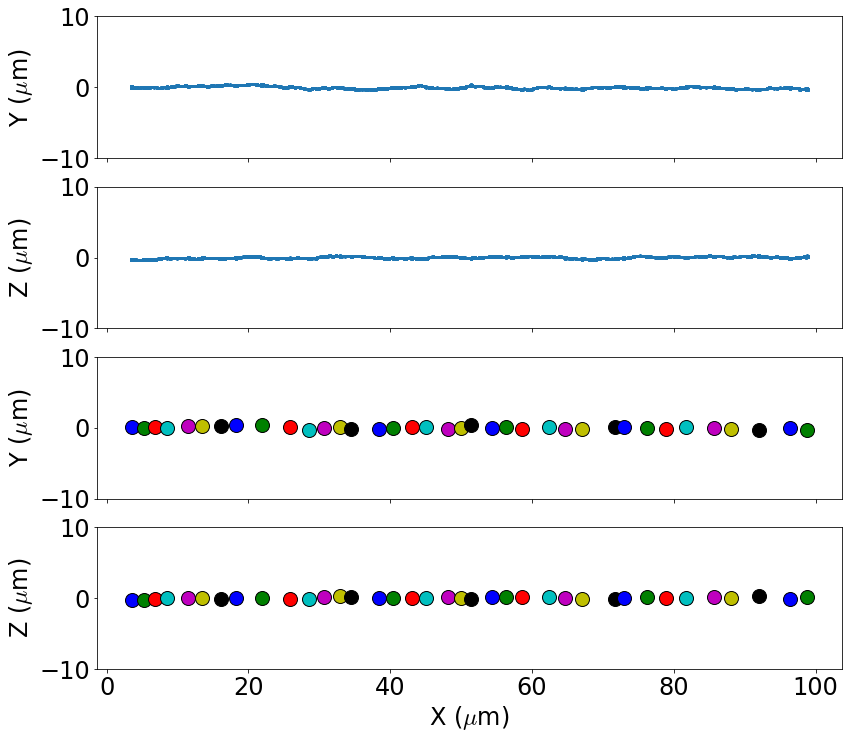

In [104]:
data_path = (ceph_path /"22-07-12_aLc1_line16000_sticky_100um")
ss_ind = 0
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    # analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
        com_arr[:, :, -1])

    cgf.graph_clust_snapshot(axarr, com_arr[:,:,-1], clust, cluster_centers, cluster_label_inds)
    for ax in axarr:
        ax.set_ylim(-10,10)

/cm/shared/sw/nix/store/ma56jkd87lypmn6r2zscpz42qz4a5gic-py-numpy-1.20.3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/cm/shared/sw/nix/store/ma56jkd87lypmn6r2zscpz42qz4a5gic-py-numpy-1.20.3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


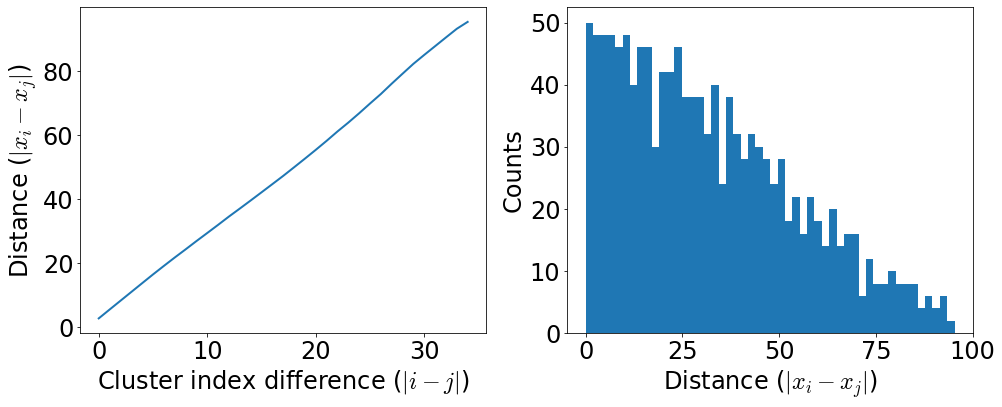

In [7]:
clust_cen_arr = np.array(sorted(cluster_centers, key = lambda x: x[0]))

sep_mat = clust_cen_arr[:, np.newaxis, 0] - clust_cen_arr[np.newaxis, :, 0] 
avg_dist_arr = [] 
avg_dist_sem_arr = []
fig, axarr = plt.subplots(1,2, figsize=(16, 6))

for i in range(1,sep_mat.shape[0]):
        diag = np.diagonal(sep_mat, i)
        avg_dist_arr += [diag.mean()]
        avg_dist_sem_arr += [stats.sem(diag)]
        
_ = axarr[0].plot(np.abs(avg_dist_arr))
_ = axarr[0].set_ylabel("Distance ($|x_i - x_j|$)")
_ = axarr[0].set_xlabel("Cluster index difference ($|i-j|$)")
_ = axarr[1].hist(np.abs(sep_mat.flatten()), bins=50)
_ = axarr[1].set_ylabel("Counts")
_ = axarr[1].set_xlabel("Distance ($|x_i - x_j|$)")

Average over multiple time points to get better statistics. (probably wont work)

(729,)
number of estimated clusters : 68
number of thresholded clusters : 53


NameError: name 'clust_cen_arr' is not defined

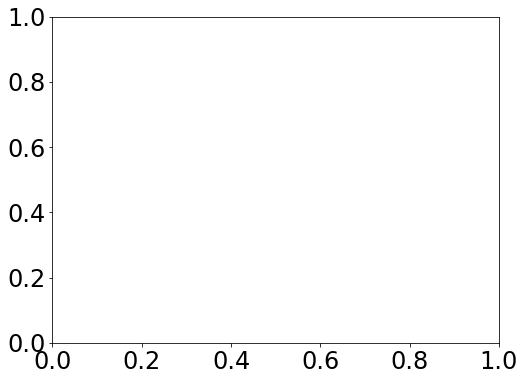

In [100]:
data_path = (ceph_path /"22-07-12_aLc1_line16000_sticky_100um")
ss_ind = 200
end_ind = -1
start_bead = 0
end_bead = None
N = 10

fig, axarr = plt.subplots(1,1, figsize=(8, 6))

with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    # analysis_grp = h5_data['analysis']
    print(time_arr.shape)

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    sep_arr = np.array([])

    for i in range(0,N):
        diff = int(time_arr.size / N)
        clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
            com_arr[:, :, diff*i])
        sep_mat = clust_cen_arr[:, np.newaxis, 0] - clust_cen_arr[np.newaxis, :, 0] 
        sep_arr = np.concatenate((sep_arr,np.abs(sep_mat.flatten())))
    _ = axarr.hist(sep_arr, bins=50)
    _ = axarr.set_ylabel("Counts")
    _ = axarr.set_xlabel("Distance ($|x_i - x_j|$)") 
    

number of estimated clusters : 41
number of thresholded clusters : 35


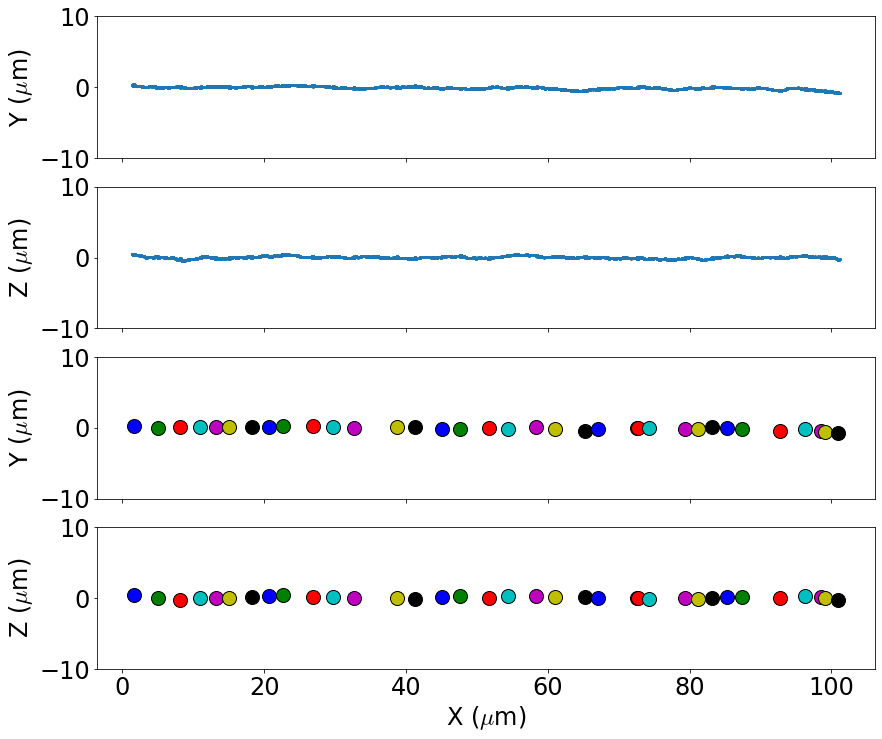

In [113]:
data_path = (ceph_path /"22-07-15_aLc1_line16000_100umconf")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    # analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
        com_arr[:, :, -1])

    cgf.graph_clust_snapshot(axarr, com_arr[:,:,-1], clust, cluster_centers, cluster_label_inds)

for ax in axarr:
    _ = ax.set_ylim(-10,10)

/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


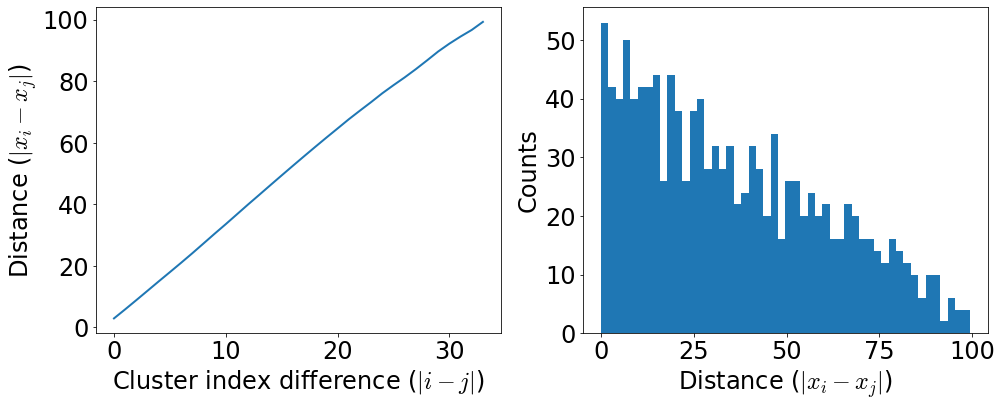

In [114]:
clust_cen_arr = np.array(sorted(cluster_centers, key = lambda x: x[0]))

sep_mat = clust_cen_arr[:, np.newaxis, 0] - clust_cen_arr[np.newaxis, :, 0] 
avg_dist_arr = [] 
avg_dist_sem_arr = []
fig, axarr = plt.subplots(1,2, figsize=(16, 6))

for i in range(1,sep_mat.shape[0]):
        diag = np.diagonal(sep_mat, i)
        avg_dist_arr += [diag.mean()]
        avg_dist_sem_arr += [stats.sem(diag)]
        
_ = axarr[0].plot(np.abs(avg_dist_arr))
_ = axarr[0].set_ylabel("Distance ($|x_i - x_j|$)")
_ = axarr[0].set_xlabel("Cluster index difference ($|i-j|$)")
_ = axarr[1].hist(np.abs(sep_mat.flatten()), bins=50)
_ = axarr[1].set_ylabel("Counts")
_ = axarr[1].set_xlabel("Distance ($|x_i - x_j|$)")

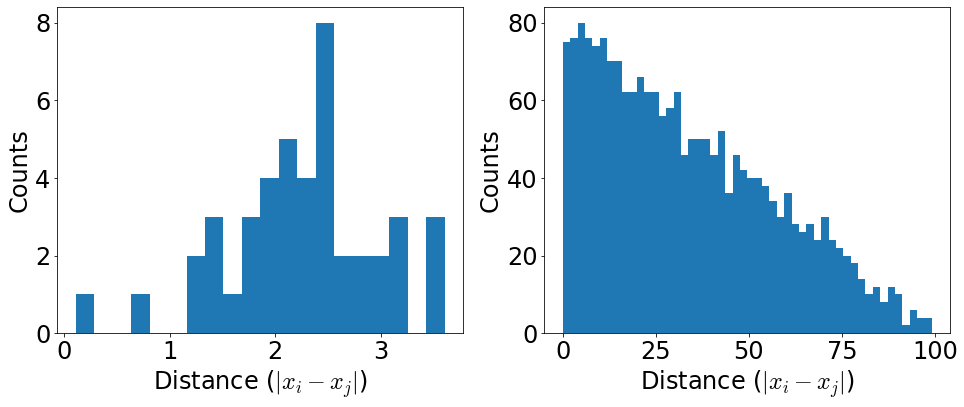

In [22]:
clust_cen_arr = np.array(sorted(cluster_centers, key = lambda x: x[0]))

sep_mat = clust_cen_arr[:, np.newaxis, 0] - clust_cen_arr[np.newaxis, :, 0] 
avg_dist_arr = [] 
avg_dist_sem_arr = []
fig, axarr = plt.subplots(1,2, figsize=(16, 6))

# for i in range(1,sep_mat.shape[0]):
#         diag = np.diagonal(sep_mat, i)
#         avg_dist_arr += [diag.mean()]
#         avg_dist_sem_arr += [stats.sem(diag)]
diag = np.abs(np.diagonal(sep_mat, 1))
        
# _ = axarr[0].plot(np.abs(avg_dist_arr))
_ = axarr[0].hist(diag, bins=20)
_ = axarr[0].set_ylabel("Counts")
_ = axarr[0].set_xlabel("Distance ($|x_i - x_j|$)")
# _ = axarr[0].set_ylabel("Distance ($|x_i - x_j|$)")
# _ = axarr[0].set_xlabel("Cluster index difference ($|i-j|$)")
_ = axarr[1].hist(np.abs(sep_mat.flatten()), bins=50)
_ = axarr[1].set_ylabel("Counts")
_ = axarr[1].set_xlabel("Distance ($|x_i - x_j|$)")

(199,)
number of estimated clusters : 45
number of thresholded clusters : 37
number of estimated clusters : 39
number of thresholded clusters : 34
number of estimated clusters : 37
number of thresholded clusters : 34
number of estimated clusters : 35
number of thresholded clusters : 34
number of estimated clusters : 37
number of thresholded clusters : 35


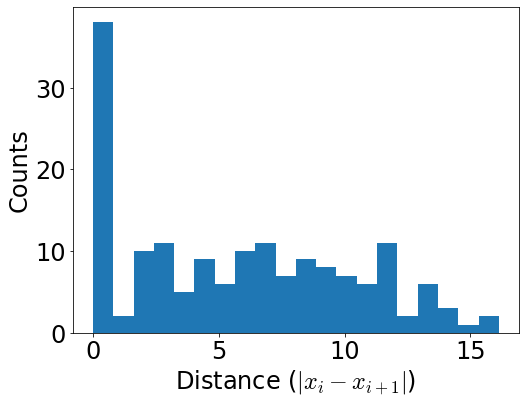

In [112]:
data_path = (ceph_path /"22-07-15_aLc1_line16000_100umconf")
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

ss_ind = -200
end_ind = -1

with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    # analysis_grp = h5_data['analysis']
    print(time_arr.shape)

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    sep_arr = np.array([])
    N = 5
    for i in range(0,N):
        diff = int(time_arr.size / N)
        clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
            com_arr[:, :, diff*i])
        cluster_centers = np.array(cluster_centers)
        sep_mat = cluster_centers[:, np.newaxis, 0] - cluster_centers[np.newaxis, :, 0] 
        sep_arr = np.concatenate((sep_arr, np.abs(np.diagonal(sep_mat,i))))
    _ = axarr.hist(sep_arr, bins=20)
    _ = axarr.set_ylabel("Counts")
    _ = axarr.set_xlabel("Distance ($|x_i - x_{i+1}|$)") 


In [10]:
data_dict = {
    "time_arr": time_arr.tolist(),
    "cluster_center_list" : [[c.tolist() for c in t] for t in clust_cent_list],
    "cluster_label_list" : [[c.tolist() for c in t] for t in clust_label_list],
}
with (data_path / 'analysis/clust_data.yaml').open('w') as yf:
    yaml.dump(data_dict, yf)

In [50]:
with (data_path / 'analysis/clust_data.yaml').open('r') as yf:
    data_dict = yaml.safe_load(yf)

/tmp/ipykernel_1184673/3139124910.py:27: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axarr[1,0].pcolor(X, Y, bead_ind_arr)


Text(0, 0.5, '$x$-position ($\\mu$m)')

Text(0, 0.5, 'Number of clusters')

Text(0, 0.5, 'Bead index')

Text(0, 0.5, 'Number of beads in clusters')

Text(0.5, 0, 'Time (sec)')

Text(0.5, 0, 'Time (sec)')

Text(0.5, 0, 'Time (sec)')

Text(0.5, 0, 'Time (sec)')

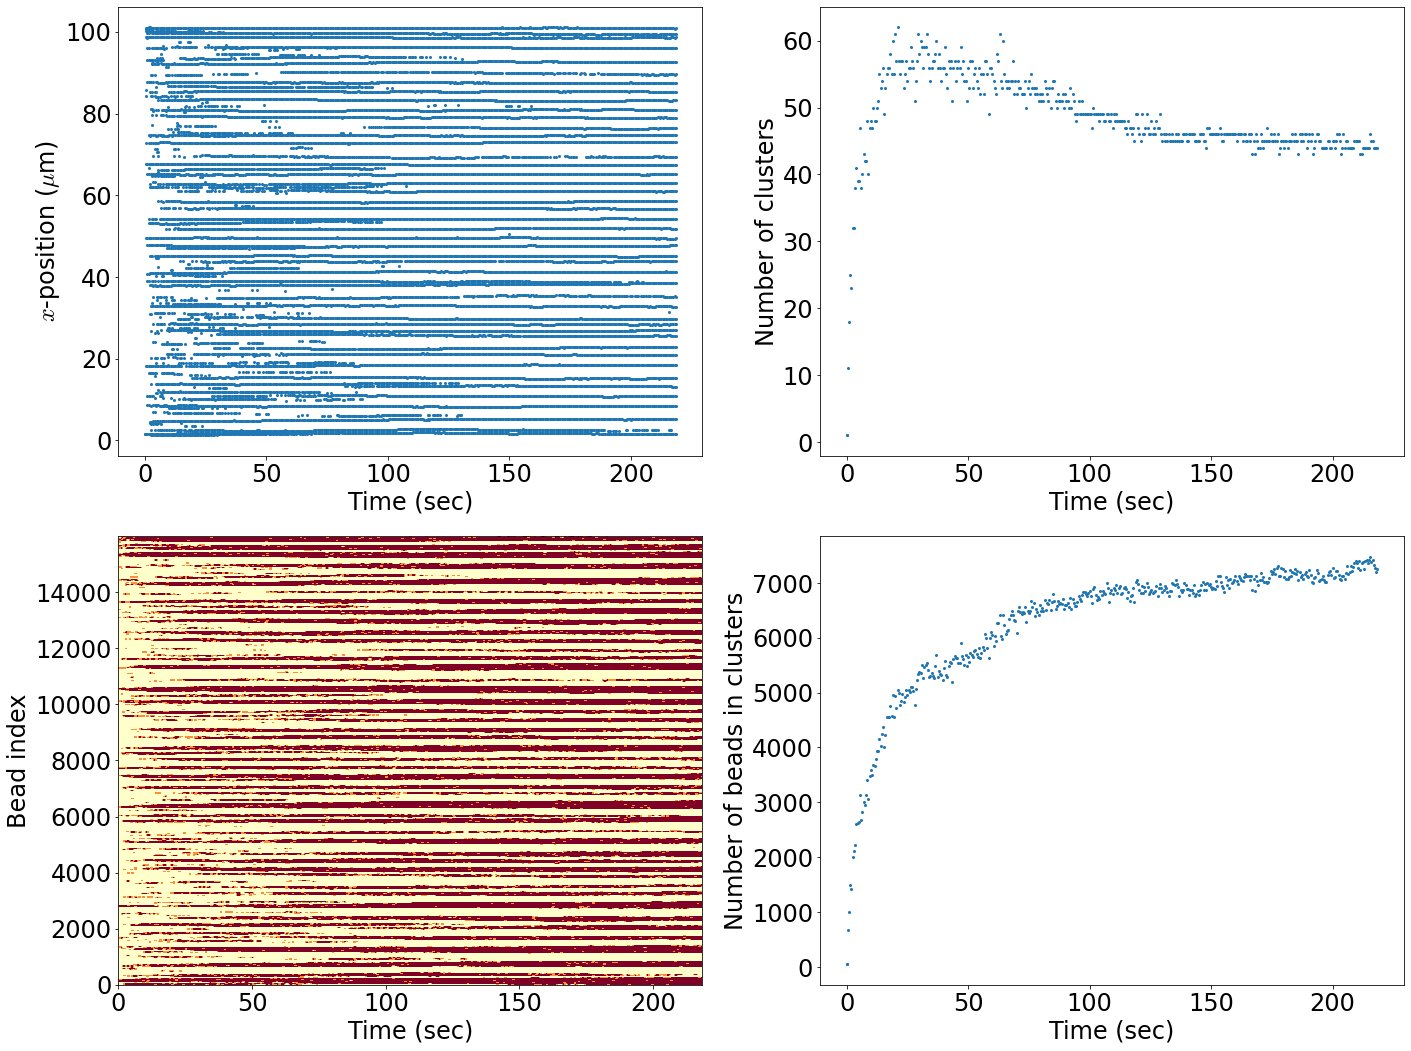

In [23]:
fig, axarr = plt.subplots(2,2, figsize=(20, 15))
flat_time_arr = []
flat_clust_cent_arr = []
flat_clust_ind_arr = []
num_clusters_list = []
num_cluster_beads_list = []
for c, clust_grp in enumerate(clust_cent_list):
    num_clusters_list += [len(clust_grp)]
    num_beads = 0
    for i, clust_cent in enumerate(clust_grp):
        flat_time_arr += [time_arr[c]]
        flat_clust_cent_arr += [clust_cent]
        flat_clust_ind_arr += [clust_label_list[c][i]]
        num_beads += len(clust_label_list[c][i])

    num_cluster_beads_list += [num_beads]

    
bead_ind_arr = np.zeros((com_arr.shape[0], com_arr.shape[2]))
one_mask = np.ones(com_arr.shape[0])
for c, clust_cli_grp in enumerate(clust_label_list):
    for cli in clust_cli_grp:
        bead_ind_arr[cli,c] += one_mask[cli]
bead_ind_arr[:,:-1] += bead_ind_arr[:,1:]
bead_ind_arr *= .5
X, Y = np.meshgrid(time_arr, np.arange(com_arr.shape[0]))
axarr[1,0].pcolor(X, Y, bead_ind_arr)

flat_clust_cent_arr = np.asarray(flat_clust_cent_arr)
_ = axarr[0,0].scatter(flat_time_arr, flat_clust_cent_arr[:,0])
_ = axarr[0,1].scatter(time_arr, num_clusters_list)
#axarr[1,0].scatter(flat_time_arr, flat_clust_ind_arr)
_ = axarr[1,1].scatter(time_arr, num_cluster_beads_list)
_ = axarr[0,0].set_ylabel('$x$-position ($\mu$m)')
_ = axarr[0,1].set_ylabel('Number of clusters')
_ = axarr[1,0].set_ylabel('Bead index')
_ = axarr[1,1].set_ylabel('Number of beads in clusters')
for ax in axarr.flatten():
    _ = ax.set_xlabel('Time (sec)')
fig.tight_layout()

/tmp/ipykernel_1184673/2580106442.py:33: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axarr[1,0].pcolor(X, Y, bead_ind_arr)


Text(0, 0.5, '$x$-position ($\\mu$m)')

Text(0, 0.5, 'Number of clusters')

Text(0, 0.5, 'Bead index')

Text(0, 0.5, 'Number of beads in clusters')

Text(0.5, 0, 'Time (sec)')

Text(0.5, 0, 'Time (sec)')

Text(0.5, 0, 'Time (sec)')

Text(0.5, 0, 'Time (sec)')

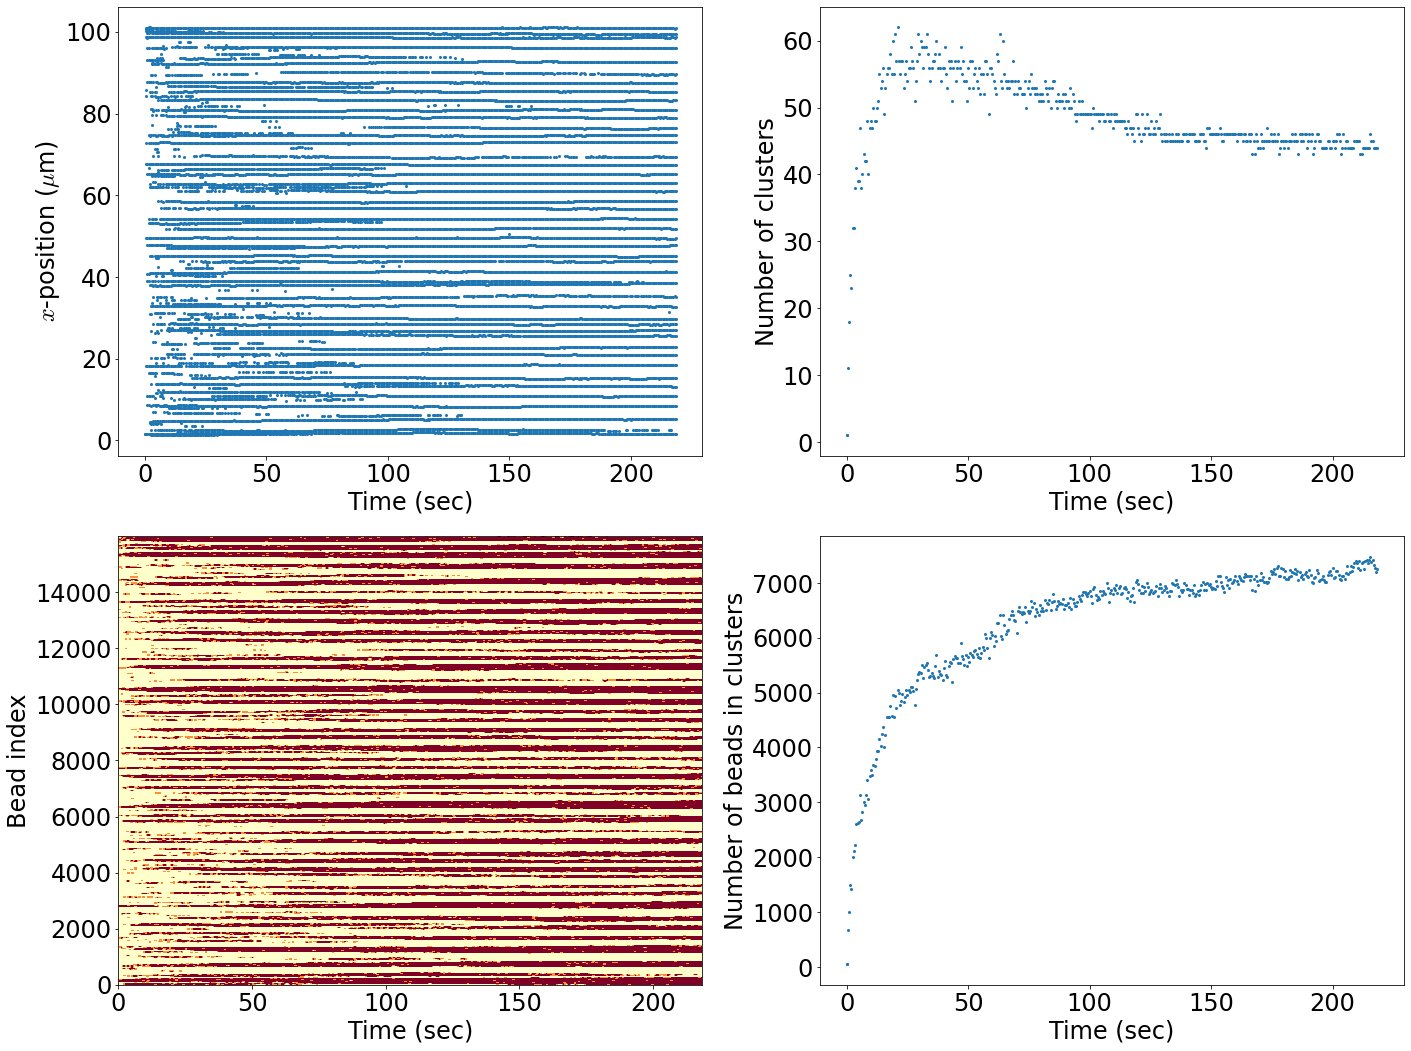

In [27]:
data_path = (ceph_path /"22-07-15_aLc1_line16000_100umconf")
with (data_path / 'analysis/data.yaml').open('r') as yf:
    data_dict = yaml.safe_load(yf)
clust_label_list_ = data_dict["cluster_label_list"]
clust_cent_list_ = data_dict["cluster_center_list"]
time_arr_ = np.array(data_dict["time_arr"])

fig, axarr = plt.subplots(2,2, figsize=(20, 15))
flat_time_arr = []
flat_clust_cent_arr = []
flat_clust_ind_arr = []
num_clusters_list = []
num_cluster_beads_list = []
for c, clust_grp in enumerate(clust_cent_list):
    num_clusters_list += [len(clust_grp)]
    num_beads = 0
    for i, clust_cent in enumerate(clust_grp):
        flat_time_arr += [time_arr[c]]
        flat_clust_cent_arr += [clust_cent]
        flat_clust_ind_arr += [clust_label_list[c][i]]
        num_beads += len(clust_label_list[c][i])

    num_cluster_beads_list += [num_beads]

    
bead_ind_arr = np.zeros((com_arr.shape[0], com_arr.shape[2]))
one_mask = np.ones(com_arr.shape[0])
for c, clust_cli_grp in enumerate(clust_label_list):
    for cli in clust_cli_grp:
        bead_ind_arr[cli,c] += one_mask[cli]
bead_ind_arr[:,:-1] += bead_ind_arr[:,1:]
bead_ind_arr *= .5
X, Y = np.meshgrid(time_arr, np.arange(com_arr.shape[0]))
axarr[1,0].pcolor(X, Y, bead_ind_arr)

flat_clust_cent_arr = np.asarray(flat_clust_cent_arr)
_ = axarr[0,0].scatter(flat_time_arr, flat_clust_cent_arr[:,0])
_ = axarr[0,1].scatter(time_arr, num_clusters_list)
#axarr[1,0].scatter(flat_time_arr, flat_clust_ind_arr)
_ = axarr[1,1].scatter(time_arr, num_cluster_beads_list)
_ = axarr[0,0].set_ylabel('$x$-position ($\mu$m)')
_ = axarr[0,1].set_ylabel('Number of clusters')
_ = axarr[1,0].set_ylabel('Bead index')
_ = axarr[1,1].set_ylabel('Number of beads in clusters')
for ax in axarr.flatten():
    _ = ax.set_xlabel('Time (sec)')
fig.tight_layout()

NameError: name 'clust_cent_list' is not defined

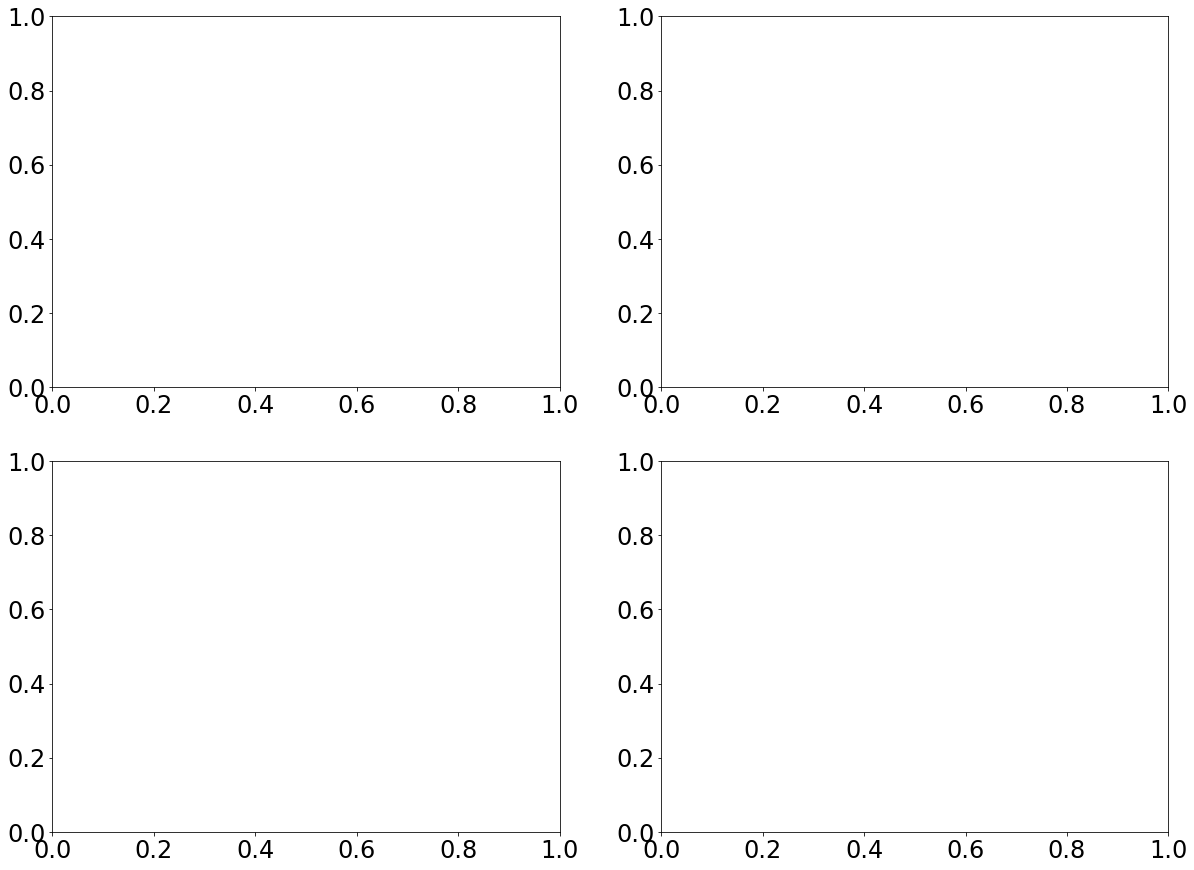

In [98]:
data_path = (ceph_path /"22-07-12_aLc1_line16000_sticky_100um")
with (data_path / 'analysis/clust_data.yaml').open('r') as yf:
    data_dict = yaml.safe_load(yf)
clust_label_list_ = data_dict["cluster_label_list"]
clust_cent_list_ = data_dict["cluster_center_list"]
time_arr_ = np.array(data_dict["time_arr"])



/tmp/ipykernel_2784479/3663827904.py:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axarr[1,0].pcolor(X, Y, bead_ind_arr)


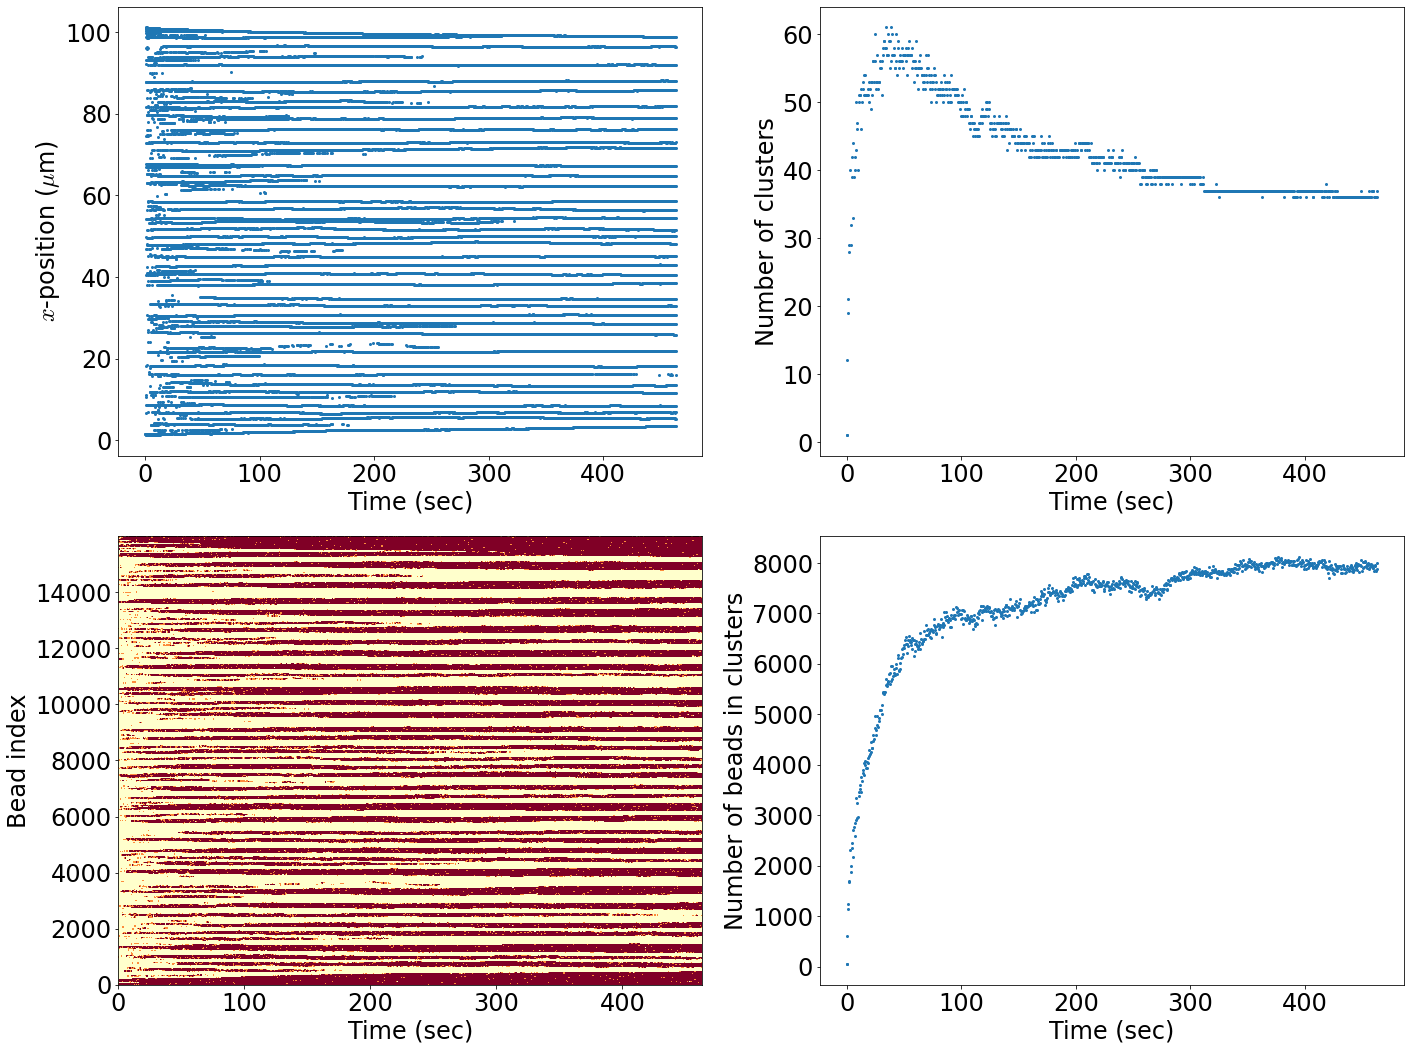

In [105]:
fig, axarr = plt.subplots(2,2, figsize=(20, 15))
flat_time_arr = []
flat_clust_cent_arr = []
flat_clust_ind_arr = []
num_clusters_list = []
num_cluster_beads_list = []
for c, clust_grp in enumerate(clust_cent_list_):
    num_clusters_list += [len(clust_grp)]
    num_beads = 0
    for i, clust_cent in enumerate(clust_grp):
        flat_time_arr += [time_arr[c]]
        flat_clust_cent_arr += [clust_cent]
        flat_clust_ind_arr += [clust_label_list_[c][i]]
        num_beads += len(clust_label_list_[c][i])

    num_cluster_beads_list += [num_beads]


    
bead_ind_arr = np.zeros((com_arr.shape[0], com_arr.shape[2]))
one_mask = np.ones(com_arr.shape[0])
for c, clust_cli_grp in enumerate(clust_label_list_):
    for cli in clust_cli_grp:
        bead_ind_arr[cli,c] += one_mask[cli]
bead_ind_arr[:,:-1] += bead_ind_arr[:,1:]
bead_ind_arr *= .5
X, Y = np.meshgrid(time_arr, np.arange(com_arr.shape[0]))
axarr[1,0].pcolor(X, Y, bead_ind_arr)

flat_clust_cent_arr = np.asarray(flat_clust_cent_arr)
_ = axarr[0,0].scatter(flat_time_arr, flat_clust_cent_arr[:,0])
_ = axarr[0,1].scatter(time_arr, num_clusters_list)
#axarr[1,0].scatter(flat_time_arr, flat_clust_ind_arr)
_ = axarr[1,1].scatter(time_arr, num_cluster_beads_list)
_ = axarr[0,0].set_ylabel('$x$-position ($\mu$m)')
_ = axarr[0,1].set_ylabel('Number of clusters')
_ = axarr[1,0].set_ylabel('Bead index')
_ = axarr[1,1].set_ylabel('Number of beads in clusters')
for ax in axarr.flatten():
    _ = ax.set_xlabel('Time (sec)')
fig.tight_layout()

number of estimated clusters : 41
number of thresholded clusters : 37


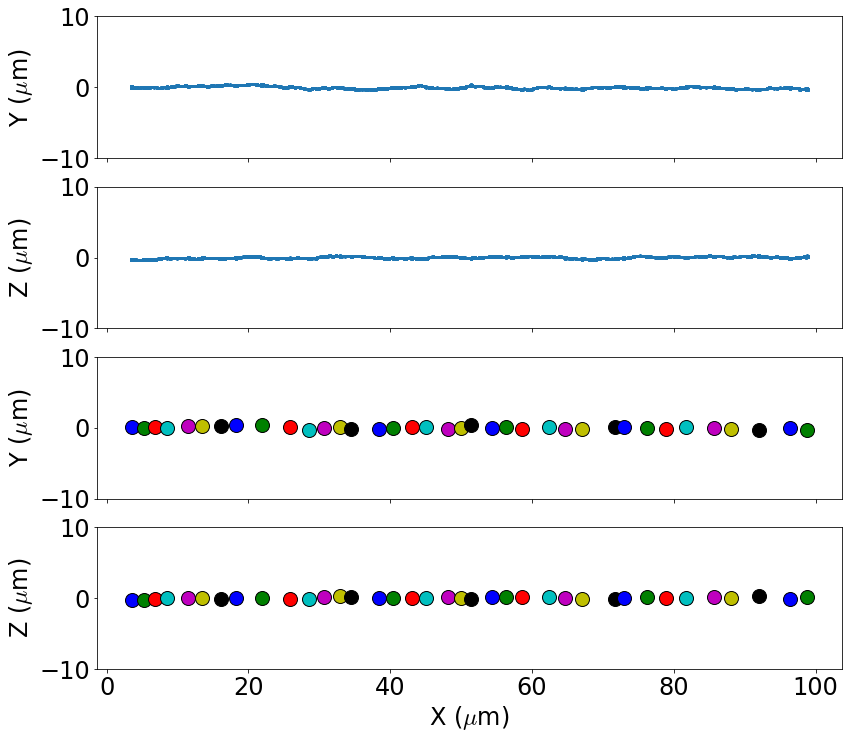

In [115]:
data_path = (ceph_path /"22-07-12_aLc1_line16000_sticky_100um")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    # analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
        com_arr[:, :, -1])

    cgf.graph_clust_snapshot(axarr, com_arr[:,:,-1], clust, cluster_centers, cluster_label_inds)

for ax in axarr:
    _ = ax.set_ylim(-10,10)

0.0


In [ ]:
n_clusters = len(cluster_centers)
for k, my_members, col in zip(range(n_clusters), cluster_label_inds, colors):

## Clusters over time

30.661806344985962
0.30661806344985965


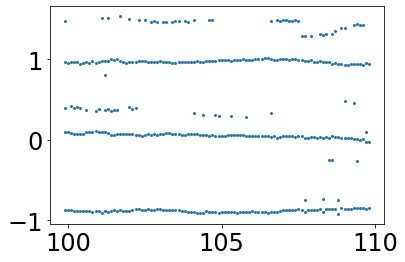

In [7]:
data_path = (ceph_path /"21-12-05_aLchr1_scan.12_line700_2xsticky_3umconf/simulations/s10")
ss_ind = 1000
end_ind = -1
start_bead = 0
end_bead = None

#fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    
    cluster_lst = []
    prof_time_arr = []
    cluster_center_lst = []
    for i in range(100):
        t0 = time.time()
        X = com_arr[:,:,i]
        cluster_centers = []

        # db = DBSCAN(eps=0.05, min_samples=15).fit(X)
        clust = OPTICS(min_samples=14, eps=0.045, cluster_method='dbscan')


        # Run the fit
        _ = clust.fit(X)
        labels = clust.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

       #print("number of estimated clusters : %d" % n_clusters_)


        cluster_label_inds = [np.where(labels == k) for k in range(n_clusters_)]
        for k in range(n_clusters_):
            cli = np.where(labels == k)[0]
            if cli.size < 20:
                continue
            cluster_label_inds += [ cli ]
            cluster_centers += [X[cli,:].mean(axis=0)]
            # my_members = labels == k

        cluster_lst += [cluster_label_inds]
        cluster_center_lst += [cluster_centers]
        prof_time_arr += [time.time() - t0]

    flat_time_arr = []
    flat_clust_cent_arr = []
    for c, clust_grp in enumerate(cluster_center_lst):
        for clust_cent in clust_grp:
            flat_time_arr += [time_arr[c]]
            flat_clust_cent_arr += [clust_cent]
    
    flat_clust_cent_arr = np.asarray(flat_clust_cent_arr)
    tot_prof_time = np.sum(prof_time_arr)
    mean_prof_time = np.mean(prof_time_arr)
    
    plt.scatter(flat_time_arr, flat_clust_cent_arr[:,0])
    print(tot_prof_time)
    print(mean_prof_time)
    
    #bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

34.89495635032654
0.3489495635032654


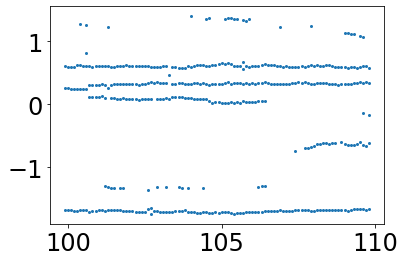

In [146]:
data_path = (ceph_path /"21-11-30_aLchr1_scan.12_line700_2xsticky_conf/simulations/s6")
ss_ind = 600
end_ind = -1
start_bead = 0
end_bead = None

#fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    
    cluster_lst = []
    prof_time_arr = []
    cluster_center_lst = []
    for i in range(1000):
        t0 = time.time()
        X = com_arr[:,:,i]
        cluster_centers = []

        # db = DBSCAN(eps=0.05, min_samples=15).fit(X)
        clust = OPTICS(min_samples=14, eps=0.045, cluster_method='dbscan')


        # Run the fit
        _ = clust.fit(X)
        labels = clust.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

       #print("number of estimated clusters : %d" % n_clusters_)


        cluster_label_inds = [np.where(labels == k) for k in range(n_clusters_)]
        for k in range(n_clusters_):
            cli = np.where(labels == k)[0]
            if cli.size < 20:
                continue
            cluster_label_inds += [ cli ]
            cluster_centers += [X[cli,:].mean(axis=0)]
            # my_members = labels == k

        cluster_lst += [cluster_label_inds]
        cluster_center_lst += [cluster_centers]
        prof_time_arr += [time.time() - t0]

    flat_time_arr = []
    flat_clust_cent_arr = []
    for c, clust_grp in enumerate(cluster_center_lst):
        for clust_cent in clust_grp:
            flat_time_arr += [time_arr[c]]
            flat_clust_cent_arr += [clust_cent]
    
    flat_clust_cent_arr = np.asarray(flat_clust_cent_arr)
    tot_prof_time = np.sum(prof_time_arr)
    mean_prof_time = np.mean(prof_time_arr)
    
    plt.scatter(flat_time_arr, flat_clust_cent_arr[:,0])
    print(tot_prof_time)
    print(mean_prof_time)
    
    #bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


623.9818077087402
0.3119909038543701


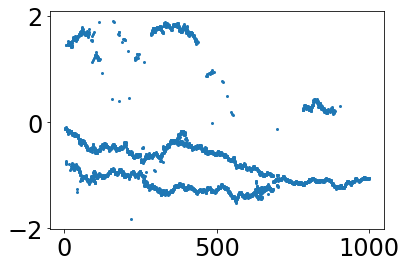

In [3]:
data_path = (ceph_path /"22-01-06_aLchr1_scan8.12_line700_2xsticky_4umconf_ko.1-300/simulations/kod1/s6")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

#fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    
    cluster_lst = []
    prof_time_arr = []
    cluster_center_lst = []
    for i in range(2000):
        t0 = time.time()
        X = com_arr[:,:,i]
        cluster_centers = []

        # Run OPTICS: min_sample=
        clust = OPTICS(min_samples=14, eps=0.045, cluster_method='dbscan')


        # Run the fit
        _ = clust.fit(X)
        labels = clust.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

       #print("number of estimated clusters : %d" % n_clusters_)


        cluster_label_inds = [np.where(labels == k) for k in range(n_clusters_)]
        for k in range(n_clusters_):
            cli = np.where(labels == k)[0]
            if cli.size < 50:
                continue
            cluster_label_inds += [ cli ]
            cluster_centers += [X[cli,:].mean(axis=0)]
            # my_members = labels == k

        cluster_lst += [cluster_label_inds]
        cluster_center_lst += [cluster_centers]
        prof_time_arr += [time.time() - t0]

    flat_time_arr = []
    flat_clust_cent_arr = []
    for c, clust_grp in enumerate(cluster_center_lst):
        for clust_cent in clust_grp:
            flat_time_arr += [time_arr[c]]
            flat_clust_cent_arr += [clust_cent]
    
    flat_clust_cent_arr = np.asarray(flat_clust_cent_arr)
    tot_prof_time = np.sum(prof_time_arr)
    mean_prof_time = np.mean(prof_time_arr)
    
    plt.scatter(flat_time_arr, flat_clust_cent_arr[:,0])
    print(tot_prof_time)
    print(mean_prof_time)
    
time_clust = OPTICS(min_samples=10, eps=0.1, cluster_method='dbscan')
time_scale = .005    #bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

## Center clustering in the time dimension

number of estimated clusters : 5


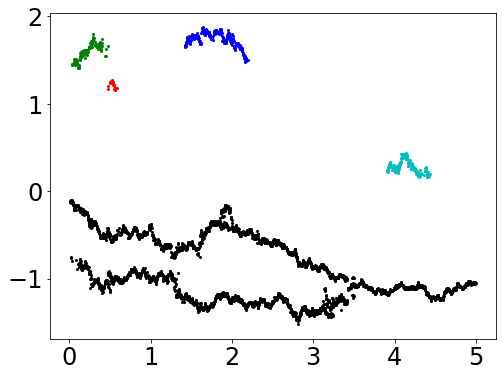

In [13]:
time_clust = OPTICS(min_samples=10, eps=0.1, cluster_method='dbscan')
time_scale = .005
flat_time_arr = np.asarray(flat_time_arr)
time_space_clust_cent_arr = np.hstack((time_scale * flat_time_arr[:,np.newaxis], flat_clust_cent_arr))


_ = time_clust.fit(time_space_clust_cent_arr)
labels = time_clust.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("number of estimated clusters : %d" % n_clusters_)

fig, axarr = plt.subplots(1, 1, figsize=(8, 6))
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    n_members = np.where(labels == k)[0].size
    # print(np.where(labels == k)[0].size)
    if n_members < 5:
        continue
    
    #cluster_center = cluster_centers[k]
    _ = axarr.scatter(time_space_clust_cent_arr[my_members, 0], time_space_clust_cent_arr[my_members, 1], color=col)

#     _ = axarr[3].scatter(X[my_members, 0], X[my_members, 2], color=col)
# for k, col in zip(range(n_



number of estimated clusters : 5


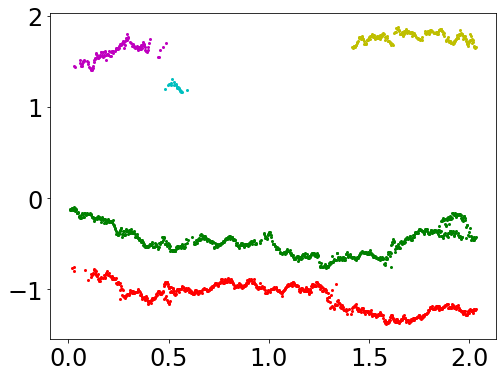

In [12]:
time_clust = OPTICS(min_samples=10, eps=0.1, cluster_method='dbscan')
time_scale = .005
flat_time_arr = np.asarray(flat_time_arr)
time_space_clust_cent_arr = np.hstack((time_scale * flat_time_arr[:,np.newaxis], flat_clust_cent_arr))[:2000]


_ = time_clust.fit(time_space_clust_cent_arr)
labels = time_clust.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("number of estimated clusters : %d" % n_clusters_)

fig, axarr = plt.subplots(1, 1, figsize=(8, 6))
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    n_members = np.where(labels == k)[0].size
    # print(np.where(labels == k)[0].size)
    if n_members < 5:
        continue
    
    #cluster_center = cluster_centers[k]
    _ = axarr.scatter(time_space_clust_cent_arr[my_members, 0], time_space_clust_cent_arr[my_members, 1], color=col)

#     _ = axarr[3].scatter(X[my_members, 0], X[my_members, 2], color=col)
# for k, col in zip(range(n_



743.3069474697113
0.37165347373485563


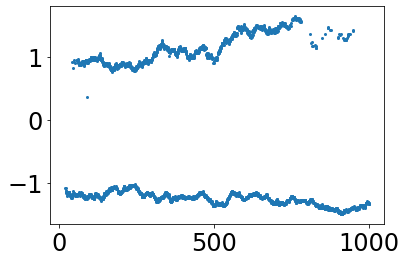

In [15]:
data_path = (ceph_path /"22-04-15_aLchr1_scan7.12_line800_stickyL.01-.07_eps1_Ke30_5umconf/simulations/Ls0.07/s1")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

#fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    
    cluster_lst = []
    prof_time_arr = []
    cluster_center_lst = []
    for i in tqdm(range(2000)):
        t0 = time.time()
        X = com_arr[:,:,i]
        cluster_centers = []

        # db = DBSCAN(eps=0.05, min_samples=15).fit(X)
        clust = OPTICS(min_samples=14, eps=0.045, cluster_method='dbscan')


        # Run the fit
        _ = clust.fit(X)
        labels = clust.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

       #print("number of estimated clusters : %d" % n_clusters_)


        cluster_label_inds = [np.where(labels == k) for k in range(n_clusters_)]
        for k in range(n_clusters_):
            cli = np.where(labels == k)[0]
            if cli.size < 50:
                continue
            cluster_label_inds += [ cli ]
            cluster_centers += [X[cli,:].mean(axis=0)]
            # my_members = labels == k

        cluster_lst += [cluster_label_inds]
        cluster_center_lst += [cluster_centers]
        prof_time_arr += [time.time() - t0]

    flat_time_arr = []
    flat_clust_cent_arr = []
    for c, clust_grp in enumerate(cluster_center_lst):
        for clust_cent in clust_grp:
            flat_time_arr += [time_arr[c]]
            flat_clust_cent_arr += [clust_cent]
    
    flat_clust_cent_arr = np.asarray(flat_clust_cent_arr)
    tot_prof_time = np.sum(prof_time_arr)
    mean_prof_time = np.mean(prof_time_arr)
    
    plt.scatter(flat_time_arr, flat_clust_cent_arr[:,0])
    print(tot_prof_time)
    print(mean_prof_time)
    
    #bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

  0%|          | 0/2000 [00:00<?, ?it/s]

760.0616588592529
0.38003082942962646


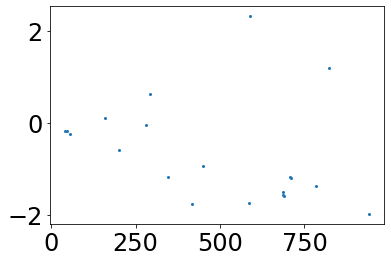

In [20]:
data_path = (ceph_path /"22-04-15_aLchr1_scan7.12_line800_stickyL.01-.07_eps1_Ke30_5umconf/simulations/Ls0.01/s1")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

#fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    
    cluster_lst = []
    prof_time_arr = []
    cluster_center_lst = []
    for i in tqdm(range(2000)):
        t0 = time.time()
        coms = com_arr[:,:,i]
        cluster_centers = []

        # db = DBSCAN(eps=0.05, min_samples=15).fit(X)
        clust = OPTICS(min_samples=14, eps=0.045, cluster_method='dbscan')


        # Run the fit
        _ = clust.fit(coms)
        labels = clust.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

       #print("number of estimated clusters : %d" % n_clusters_)


        cluster_label_inds = [np.where(labels == k) for k in range(n_clusters_)]
        for k in range(n_clusters_):
            cli = np.where(labels == k)[0]
            if cli.size < 50: # Threshold cluster size
                continue
            cluster_label_inds += [ cli ]
            cluster_centers += [coms[cli,:].mean(axis=0)]
            # my_members = labels == k

        cluster_lst += [cluster_label_inds]
        cluster_center_lst += [cluster_centers]
        prof_time_arr += [time.time() - t0]

    flat_time_arr = []
    flat_clust_cent_arr = []
    for c, clust_grp in enumerate(cluster_center_lst):
        for clust_cent in clust_grp:
            flat_time_arr += [time_arr[c]]
            flat_clust_cent_arr += [clust_cent]
    
    flat_clust_cent_arr = np.asarray(flat_clust_cent_arr)
    tot_prof_time = np.sum(prof_time_arr)
    mean_prof_time = np.mean(prof_time_arr)
    
    plt.scatter(flat_time_arr, flat_clust_cent_arr[:,0])
    print(tot_prof_time)
    print(mean_prof_time)
    
    #bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

In [3]:
data_path = (ws_path / "22-04-01_aLchr1_scan.12_line700_2xsticky_rigid700_5umconf/simulations/s7")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

#fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    
    cluster_lst = []
    prof_time_arr = []
    cluster_center_lst = []
    for i in tqdm(range(2000)):
        t0 = time.time()
        coms = com_arr[:,:,i]
        cluster_centers = []

        # db = DBSCAN(eps=0.05, min_samples=15).fit(X)
        clust = OPTICS(min_samples=14, eps=0.045, cluster_method='dbscan')


        # Run the fit
        _ = clust.fit(coms)
        labels = clust.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

       #print("number of estimated clusters : %d" % n_clusters_)


        cluster_label_inds = [np.where(labels == k) for k in range(n_clusters_)]
        for k in range(n_clusters_):
            cli = np.where(labels == k)[0]
            if cli.size < 50: # Threshold cluster size
                continue
            cluster_label_inds += [ cli ]
            cluster_centers += [coms[cli,:].mean(axis=0)]
            # my_members = labels == k

        cluster_lst += [cluster_label_inds]
        cluster_center_lst += [cluster_centers]
        prof_time_arr += [time.time() - t0]

    flat_time_arr = []
    flat_clust_cent_arr = []
    for c, clust_grp in enumerate(cluster_center_lst):
        for clust_cent in clust_grp:
            flat_time_arr += [time_arr[c]]
            flat_clust_cent_arr += [clust_cent]
    
    flat_clust_cent_arr = np.asarray(flat_clust_cent_arr)
    tot_prof_time = np.sum(prof_time_arr)
    mean_prof_time = np.mean(prof_time_arr)
    
    plt.scatter(flat_time_arr, flat_clust_cent_arr[:,0])
    print(tot_prof_time)
    print(mean_prof_time)
    
    #bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

  0%|          | 0/2000 [00:00<?, ?it/s]

NameError: name 'OPTICS' is not defined

2.0


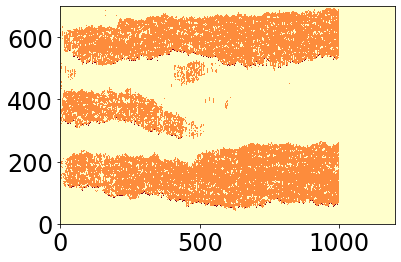

In [47]:

bead_ind_arr = np.zeros((com_arr.shape[0], com_arr.shape[2]))
one_mask = np.ones(com_arr.shape[0])
for c, clust_cli_grp in enumerate(cluster_lst):
    for cli in clust_cli_grp:
        bead_ind_arr[cli[0],c] += one_mask[cli[0]]

X, Y = np.meshgrid(time_arr, np.arange(com_arr.shape[0]))
plt.pcolor(X, Y, bead_ind_arr)

  0%|          | 0/2000 [00:00<?, ?it/s]

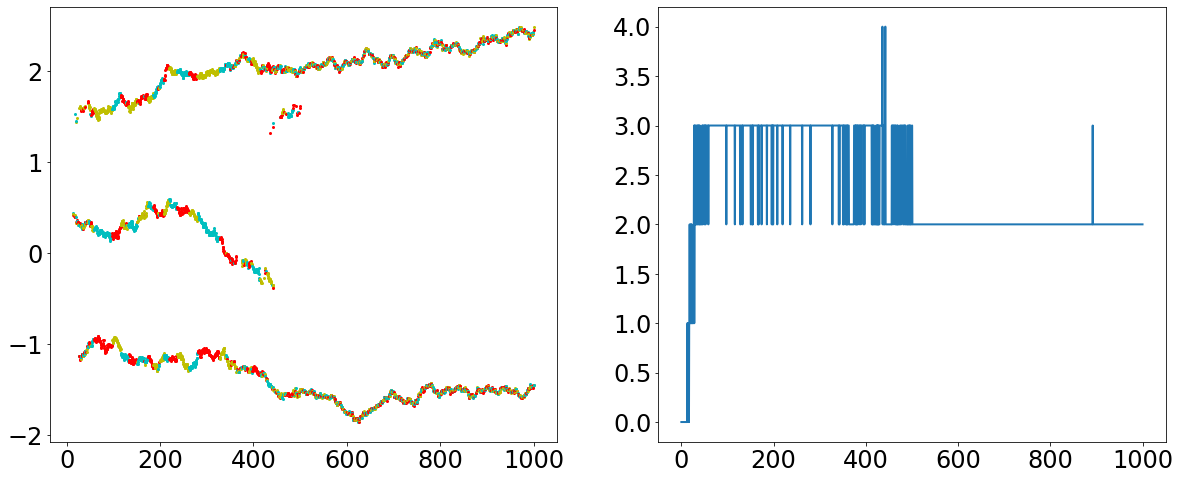

In [49]:
fig, axarr = plt.subplots(1,2, figsize=(20, 8))

colors = cycle("rcy")
clust_num_arr = []
for c, clust_grp in tqdm(enumerate(cluster_center_lst), total=len(cluster_center_lst)):
    clust_num_arr += [len(clust_grp)]
    for (clust_cent, col) in zip(clust_grp,colors):
        _ = axarr[0].scatter(time_arr[c], clust_cent[0], color=col)
_ = axarr[1].plot(time_arr[:len(clust_num_arr)], clust_num_arr)
        

In [80]:
clusters = [ [cluster[0]] for cluster in cluster_lst[100] if isinstance(cluster[0], np.ndarray)]
#print(clusters)
for cluster in tqdm(cluster_lst[100:], total = len(cluster_lst[100:])):
    for oc in clusters:
        if float(np.intersect1d(oc[-1], cluster[0]).size/len(oc[-1]))> .75:
            oc += [cluster[0]]


  0%|          | 0/1900 [00:00<?, ?it/s]

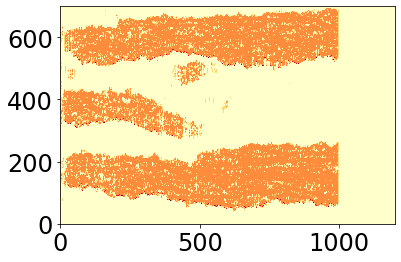

In [63]:
bead_ind_arr = np.zeros((com_arr.shape[0], com_arr.shape[2]))
one_mask = np.ones(com_arr.shape[0])
for c, clust_cli_grp in enumerate(cluster_lst):
    for cli in clust_cli_grp:
        bead_ind_arr[cli[0],c] += one_mask[cli[0]]
bead_ind_arr[:,:-1] += bead_ind_arr[:,1:]
bead_ind_arr *= .5
X, Y = np.meshgrid(time_arr, np.arange(com_arr.shape[0]))
plt.pcolor(X, Y, bead_ind_arr)

/cm/shared/sw/nix/store/ma56jkd87lypmn6r2zscpz42qz4a5gic-py-numpy-1.20.3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/cm/shared/sw/nix/store/ma56jkd87lypmn6r2zscpz42qz4a5gic-py-numpy-1.20.3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/cm/shared/sw/nix/store/ma56jkd87lypmn6r2zscpz42qz4a5gic-py-numpy-1.20.3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/cm/shared/sw/nix/store/ma56jkd87lypmn6r2zscpz42qz4a5gic-py-numpy-1.20.3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/cm/shared/sw/nix/store/ma56jkd87lypmn6r2zscpz42qz4a5gic-py-numpy-1.20.3/lib

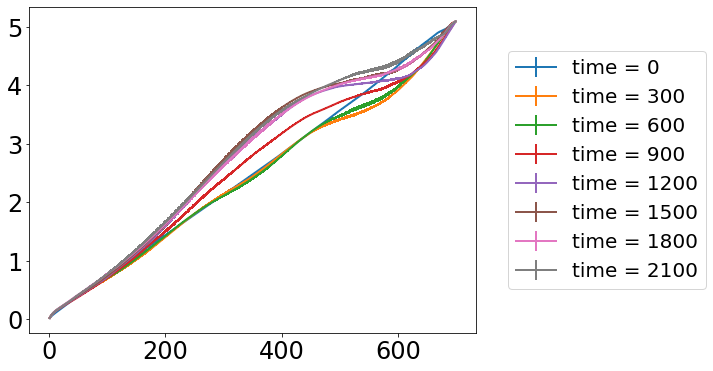

In [88]:
fig, ax = plt.subplots(figsize=(8,6))
for time_ind in np.arange(0, com_arr.shape[-1], 300):
    sep_mat = np.linalg.norm(com_arr[:, np.newaxis, :, time_ind] - com_arr[np.newaxis, :, :, time_ind], axis=2)
    #print(sep_mat)
    avg_dist_arr = []
    avg_dist_sem_arr = []
    for i in range(1,sep_mat.shape[0]):
        diag = np.diagonal(sep_mat, i)
        avg_dist_arr += [diag.mean()]
        avg_dist_sem_arr += [stats.sem(diag)]
    
    _ = ax.errorbar(np.arange(1,len(avg_dist_arr)+1), avg_dist_arr, yerr=avg_dist_sem_arr, label=f'time = {time_ind}')

_ = ax.legend(loc='center left', bbox_to_anchor=(1.05, .5))

# Constructing a merger tree

In [21]:
# Get cluster data
# data_path = ceph_path / "22-07-15_aLc1_line16000_100umconf"
ss_ind = -20
end_ind = -1
start_bead = 0
end_bead = None
data_path = (
    ceph_path / "22_aLchr700_sticky_runs/22-01-02_aLchr1_scan.12_line700_2xsticky_3umconf_eq/simulations/s6")

with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                            :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    clust_cent_list = []
    clust_label_list = []
    for i in range(time_arr.size):
        clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
            com_arr[:, :, i], thresh=40)
        clust_cent_list += [cluster_centers]
        clust_label_list += [cluster_label_inds]

number of estimated clusters : 2
number of thresholded clusters : 2
number of estimated clusters : 3
number of thresholded clusters : 2
number of estimated clusters : 3
number of thresholded clusters : 2
number of estimated clusters : 4
number of thresholded clusters : 2
number of estimated clusters : 4
number of thresholded clusters : 2
number of estimated clusters : 3
number of thresholded clusters : 2
number of estimated clusters : 4
number of thresholded clusters : 2
number of estimated clusters : 4
number of thresholded clusters : 2
number of estimated clusters : 3
number of thresholded clusters : 2
number of estimated clusters : 3
number of thresholded clusters : 2
number of estimated clusters : 3
number of thresholded clusters : 2
number of estimated clusters : 2
number of thresholded clusters : 2
number of estimated clusters : 3
number of thresholded clusters : 2
number of estimated clusters : 3
number of thresholded clusters : 2
number of estimated clusters : 2
number of thres

In [64]:
from alens_analysis import cluster_analysis as cla

clusters = []
id_gen = aa.helpers.gen_id()

for i, t in enumerate(time_arr):
    clusters += [[]]
    for clust_inds in cluster_label_inds:
        clusters[-1] += [cla.Cluster(next(id_gen), t, clust_inds)]

def find_descendants(clusters, thresh=.75):
    for i in range(len(clusters)-1):
        for cur in clusters[i]:
            best_score = 0
            best_clust = None
            for cand in clusters[i+1]: 
                score = cur.compare(cand)
                # print(score)
                if score > best_score:
                    best_score = score
                    best_clust = cand 
                    print(best_clust.id)
            if best_score > thresh * len(cur.part_ids):
                cur.poss_descendants += [best_clust]
                best_clust.poss_progenitors += [cur]

find_descendants(clusters)
for tgroup in clusters:
    for c in tgroup:
        if c.poss_descendants:
            print(c.poss_descendants[0].id)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


2
{'id': 0, 'time': 1190.5, 'part_ids': array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
       162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
       175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187,
       188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200,
       201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 213, 214,
       215, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228,
       229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241,
       242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254,
       255, 256, 257, 25

# Testing

StopIteration: 

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


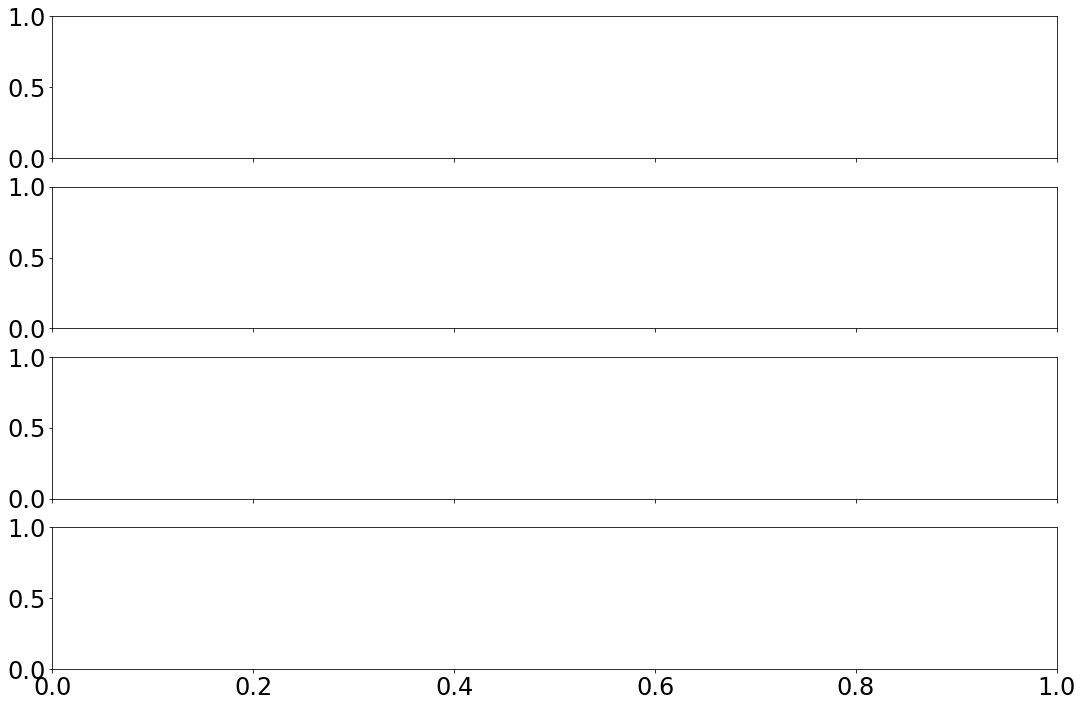

In [4]:
data_path = (ceph_path /"22-01-02_aLchr1_scan.12_line700_2xsticky_3umconf_eq/simulations/s6")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']
    
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
   
    _ =axarr[0].scatter(com_arr[:,0,-1], com_arr[:,1,-1])
    _ =axarr[1].scatter(com_arr[:,0,-1], com_arr[:,2,-1])
    _ =axarr[0].set_ylabel('Y ($\mu$m)')
    _ =axarr[1].set_ylabel('Z ($\mu$m)')
    _ =axarr[3].set_xlabel('X ($\mu$m)')
    
    X = com_arr[:,:,-1]
    
    db = DBSCAN(eps=0.05, min_samples=15).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    print("number of estimated clusters : %d" % n_clusters_)

    # Collect a list of cluster centers and the list of their labels
    cluster_centers = []
    cluster_label_inds = []
    for k in range(n_clusters_):
        cli = np.where(labels == k)[0]
        if cli.size < 50:
            continue
        cluster_label_inds += [ cli ]
        cluster_centers += [X[cli,:].mean(axis=0)]
    
    # Plot all the particles in the cluster and the cluster centers
    for k, col in zip(range(n_clusters_), colors):
        my_members = labels == k
        cluster_center = cluster_centers[k]
        _ = axarr[2].scatter(X[my_members, 0], X[my_members, 1], color=col)
        _ = axarr[2].plot(
            cluster_center[0],
            cluster_center[1],
            "o",
            markerfacecolor=col,
            markeredgecolor="k",
            markersize=14,
        )
        _ = axarr[3].scatter(X[my_members, 0], X[my_members, 2], color=col)
        _ = axarr[3].plot(
            cluster_center[0],
            cluster_center[2],
            "o",
            markerfacecolor=col,
            markeredgecolor="k",
            markersize=14,
        )

    for ax in axarr:
        _ = ax.set_aspect(1)
    